 # 20210112 - Circadian Rhythm
This notebook was made following `20220110_raw_analysis.ipynb`. This is meant to be the most basic circadian rhythm analysis possible consisting of simple binned velocity statistics by hour of the day. It is likely that we should think more about what metrics to use but as a first pass, distance travelled and time spent moving seem appropriate. As with the previous notebook, most important functions are placed in `utils/trx_utils.py`. Again, we focus on two sets of data here: `exp1_cam1` which is the first camera from our long timescale data and '24h_bright' which is a dataset I gathered last weekend with significantly increased brightness and a verified light-dark cycle. Flies from `24h_bright` are not age matched. We should note that we are, for the most part, using 24h of `exp1_cam1` and 24h of `24h_bright` data rather than the full set of tracks. Further, `24h_bright` was processed using a newer model. For associated videos, see the videos `analysis/notebooks/` and the (massive) raw videos are on google drive([long-timescale-static](https://drive.google.com/drive/u/1/folders/1BFXIEEp_KnmDSPjONEU5h-CuK0-qy4ud)).


## Broad concerns

One thing to note as you look through this notebook is the very different scales for the two datasets. `exp1_cam1` shows an *extremely* small amount of total movement compared to `24h_bright`. THis could be driven by a few difference sources: the lack of age matching for `24h_bright`, the extremely strong lighting conditions, or differences in plating(specifically the amount of food placed in each well). The flies in `24h_bright` also die earlier -- approximately 5 days in rather than ~10.

In [1]:
import logging
from seaborn.distributions import distplot
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import pandas as pd
import h5py
import numpy as np
from pathlib import Path
import os
from datetime import datetime
import importlib
import time
wd = "/Genomics/ayroleslab2/scott/long-timescale-behavior/analysis/"
os.chdir(wd)

import utils.trx_utils as trx_utils

data_dir = "/Genomics/ayroleslab2/scott/long-timescale-behavior/data/"
track_dir = "/Genomics/ayroleslab2/scott/long-timescale-behavior/data/tracks/"
plots_dir = "/Genomics/ayroleslab2/scott/long-timescale-behavior/analysis/plots/"
logs_dir = "/Genomics/ayroleslab2/scott/long-timescale-behavior/analysis/logs/"
logging.basicConfig(
    filename=f'{logs_dir}{time.strftime("%Y%m%d_%H%M%S")}_circadian_rhythm.log',
    format="%(asctime)s %(levelname)s: %(message)s",
    level=logging.INFO,
    datefmt="%H:%M:%S",
)
logger = logging.getLogger("analysis_logger")

# Plotting parameters
plots_prefix = ""
plt.rcParams["patch.linewidth"] = 0
plt.rcParams["patch.edgecolor"] = "none"
plt.rcParams["figure.figsize"] = (9, 3)
plt.rcParams["figure.dpi"] = 300

# Metadata
Build up a dict containing all of our experimental metadata so that we don't need to manually enter it all through the notebook.

In [2]:
# Stick to the first 24h for now.
exp1_cam1_h5s = [
    "exp2_cam1_0through23.tracked.analysis.h5",
    # "exp2_cam1_24through47.tracked.analysis.h5",
    # "exp2_cam1_48through71.tracked.analysis.h5",
    # "exp2_cam1_72through95.tracked.analysis.h5",
    # "exp2_cam1_96through119.tracked.analysis.h5",
]
exp1_cam1_h5s = [track_dir + filename for filename in exp1_cam1_h5s]

bright_h5s = ["24h_bright_0through23_0through29.tracked.analysis.h5"]
bright_dir = "/Genomics/ayroleslab2/scott/long-timescale-behavior/tmp/24h_bright/"
bright_h5s = [bright_dir + filename for filename in bright_h5s]

FMT = "%w-%H:%M:%S"

# Build with dict for compatibility with JSON
expmt_dict = {
    "exp1_cam1": {
        "h5s": exp1_cam1_h5s,
        "video": "exp1_cam1.mkv",
        "frame_rate": 100,
        "start_time": datetime.strptime("0-22:33:00", FMT),
        "camera": "1",
        "experiment": "1",
        "video_path": "/Genomics/ayroleslab2/scott/long-timescale-behavior/data/exp1/exp5_202109014_2233/Camera1/exp.mkv",
        "px_mm": 28.25,
    },
    "24h_bright": {
        "h5s": bright_h5s,
        "video": "/Genomics/ayroleslab2/scott/long-timescale-behavior/tmp/24h_bright/24h_bright.mkv",
        "frame_rate": 99.96,
        "start_time": datetime.strptime("0-12:00:00", FMT),
        "camera": "1",
        "experiment": "24h_bright",
        "video_path": "/Genomics/ayroleslab2/scott/long-timescale-behavior/tmp/24h_bright/24h_bright.mkv",
        "px_mm": 28.25,
    },
}
px_mm = expmt_dict["exp1_cam1"]["px_mm"]

 # Load h5 traces and match by quadrant
 For reference, fly node locations are in the form (time, node, coord, fly_idx). The frequency and assignments are logged here but are not necessary for understanding the subsequent analysis. We expect 120\*60\*60\*100 = 43,200,000 frames for first 120h of `exp1_cam1` and 24\*60\*60\*99.96 = 8,636,544 frames for `24h_bright`. The missing values here are just locations where the thorax was not identified.

In [3]:
expmt_dict,tracks_dict_raw = trx_utils.load_tracks(expmt_dict)

14:45:46 INFO: Loading exp1_cam1
14:45:46 INFO: /Genomics/ayroleslab2/scott/long-timescale-behavior/data/tracks/exp2_cam1_0through23.tracked.analysis.h5
14:46:16 INFO: Experiment: {'h5s': ['/Genomics/ayroleslab2/scott/long-timescale-behavior/data/tracks/exp2_cam1_0through23.tracked.analysis.h5'], 'video': 'exp1_cam1.mkv', 'frame_rate': 100, 'start_time': datetime.datetime(1900, 1, 1, 22, 33), 'camera': '1', 'experiment': '1', 'video_path': '/Genomics/ayroleslab2/scott/long-timescale-behavior/data/exp1/exp5_202109014_2233/Camera1/exp.mkv', 'px_mm': 28.25, 'node_names': ['head', 'eyeL', 'eyeR', 'thorax', 'abdomen', 'forelegL', 'forelegR', 'midlegL', 'midlegR', 'hindlegL', 'hindlegR', 'wingL', 'wingR', 'proboscis']}
14:46:16 INFO: Final frequencies: [array([[8639954.,       0.],
       [      0.,       0.]]), array([[      0., 8639967.],
       [      0.,       0.]]), array([[      0.,       0.],
       [8639969.,       0.]]), array([[      0.,       0.],
       [      0., 8639959.]])]
14

# Process raw tracks
Processing the raw tracks as needed and generating corresponding velocities. Note that the velocities use `np.gradient` which uses the central difference for interior points and either first order one-sided difference for the first and last point. We're not using the velocity extensively in this notebook but it's useful to use as a sanity check and helped me to select frames of interest.

In [4]:
tracks_dict = {}
velocities_dict = {}

for key in expmt_dict:
    expmt = expmt_dict[key]
    fly_node_locations = tracks_dict_raw[key].copy()
    fly_node_locations = trx_utils.fill_missing_np(fly_node_locations)

    # Calculate velocities -- central difference except on first and last frame
    fly_node_velocities = (
        trx_utils.instance_node_velocities(
            fly_node_locations, 0, fly_node_locations.shape[0]
        )
        * (1 / px_mm)
        * expmt["frame_rate"]
    )
    tracks_dict[key] = fly_node_locations
    velocities_dict[key] = fly_node_velocities

100%|██████████| 14/14 [00:05<00:00,  2.53it/s]


 # Save
 Save the JSON and h5s if needed. We'll avoid using high compression options to keep our time cost low. This is one step where we can save a ton of disk space when we're done.

In [5]:
import json
json.dump(expmt_dict, open("expmt_dict.json", "w"), default=str)

for key in tqdm(expmt_dict):
    data_file = h5py.File(data_dir + f"{key}_fly_node_locations.h5", "w")
    data_file.create_dataset(
        "tracks", data=tracks_dict[key]
    )  # , compression='lzf') #'gzip', compression_opts=9)
    data_file.close()

    data_file = h5py.File(data_dir + f"{key}_fly_node_velocities.h5", "w")
    data_file.create_dataset(
        "velocities", data=velocities_dict[key]
    )  # , compression='lzf') #'gzip', compression_opts=9)
    data_file.close()


100%|██████████| 2/2 [00:39<00:00, 19.81s/it]


# Load in processed tracks
This saves a good chunk of time by skipping the first section of the notebook.

In [6]:
import json

expmt_dict = json.load(open("expmt_dict.json", "r"))
node_names = expmt_dict["exp1_cam1"]["node_names"]
px_mm = expmt_dict["exp1_cam1"]["px_mm"]
tracks_dict = {}
velocities_dict = {}
for key in tqdm(expmt_dict):
    with h5py.File(data_dir + f"/{key}_fly_node_locations.h5", "r") as f:
        tracks_dict[key] = f["tracks"][:]
    with h5py.File(data_dir + f"/{key}_fly_node_velocities.h5", "r") as f:
        velocities_dict[key] = f["velocities"][:]


100%|██████████| 2/2 [00:55<00:00, 27.70s/it]


# Circadian rhythm

Let's take a look at whate the circadian rhythm looks like between these two datasets. We know that the lights are correctly cycling for `24h_bright` and that they are *significantly* brighter. Lets compare the two to see what might be going on.
We start off here by generating a couple of dictionaries and filling them with time of day info for each experiment.

In [7]:
import scipy.stats
from datetime import datetime
import palettable

# Generate a ToD dict containing the time of day for each frame. We take the difference from the start time to get a frame shift to "push" the start time to midnight.
# We then take frames mod (frames in a day) and divide that by the number of frames in an hour to get the time of day in hours and push it to a dictonary.

ToD = {}
for expmt in expmt_dict:
    expmt_data = expmt_dict[expmt]
    FMT = "%w-%H:%M:%S"
    start_day = datetime.strptime(
        "1900-01-01 00:00:00", "%Y-%m-%d %H:%M:%S"
    )  # for example
    try:
        time = datetime.strptime(expmt_data["start_time"], "%Y-%m-%d %H:%M:%S")
    except:
        time = expmt_data["start_time"]
    expmt_data["start_time"] = time
    difference = start_day - time
    frame_rate = expmt_data["frame_rate"]
    shift = int(difference.seconds * frame_rate)
    frame_idx = np.arange(tracks_dict[expmt].shape[0]) - shift
    expmt_tod = (frame_idx % int(24 * 60 * 60 * frame_rate)) / (
        1 * 60 * 60 * frame_rate
    )
    ToD[expmt] = expmt_tod

# Take the time of day dicttionary and binarize to day and night.
day_start = 8
day_end = 20
day_map = {0: "Night", 1: "Day"}
day_dict = {}
for expmt in expmt_dict:
    day_dict[expmt] = (ToD[expmt] > day_start) & (ToD[expmt] < day_end)


## Time of day by experiment
Now that we have these dictionaries, lets generate the mean thorax velocity by time of day. We also bin thorax velocities into two bins, "day" and "night" corresponding to lights on and lights off and plot them as a boxplot.

14:51:10 INFO: exp1_cam1
14:51:10 INFO: exp1_cam1 0
14:51:10 INFO: exp1_cam1 1
14:51:10 INFO: exp1_cam1 2
14:51:10 INFO: exp1_cam1 3


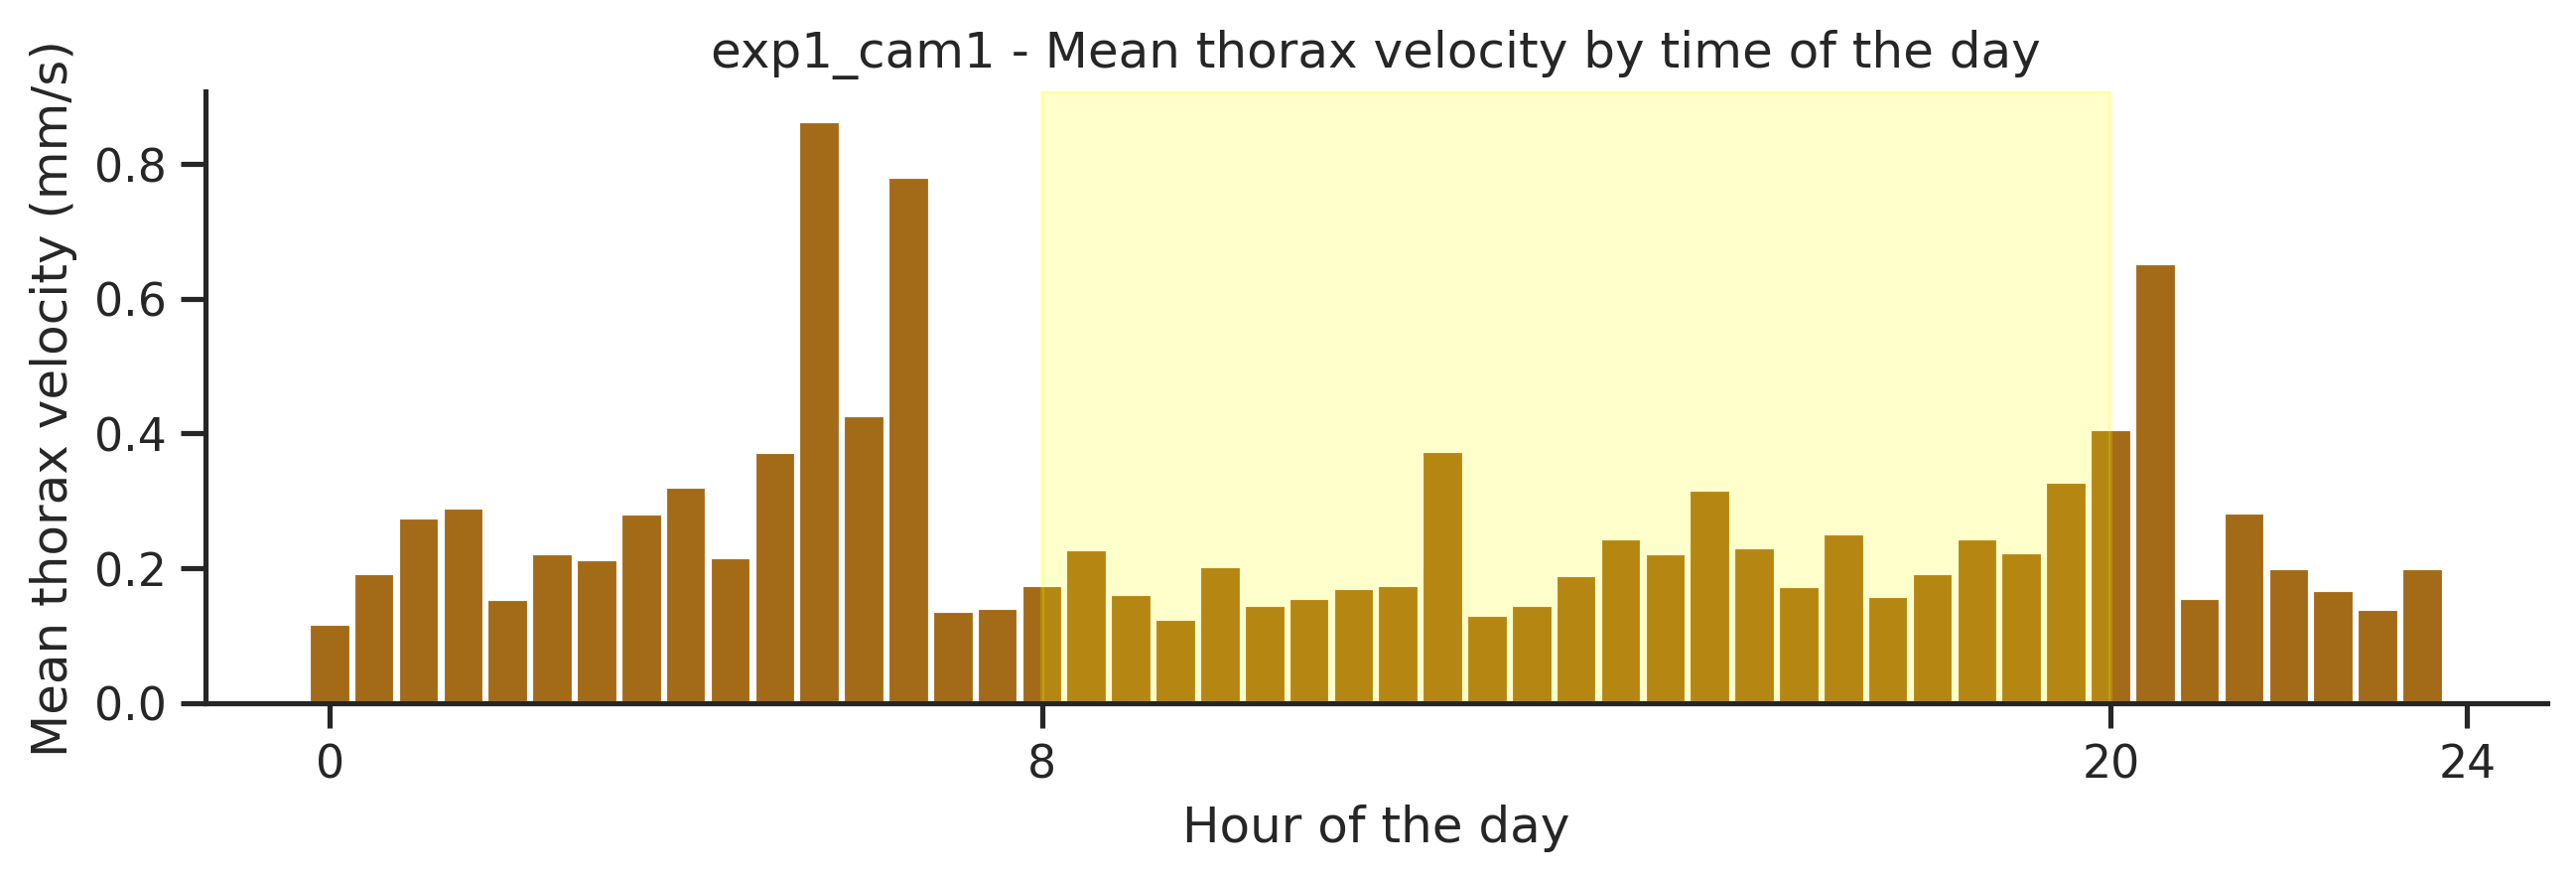

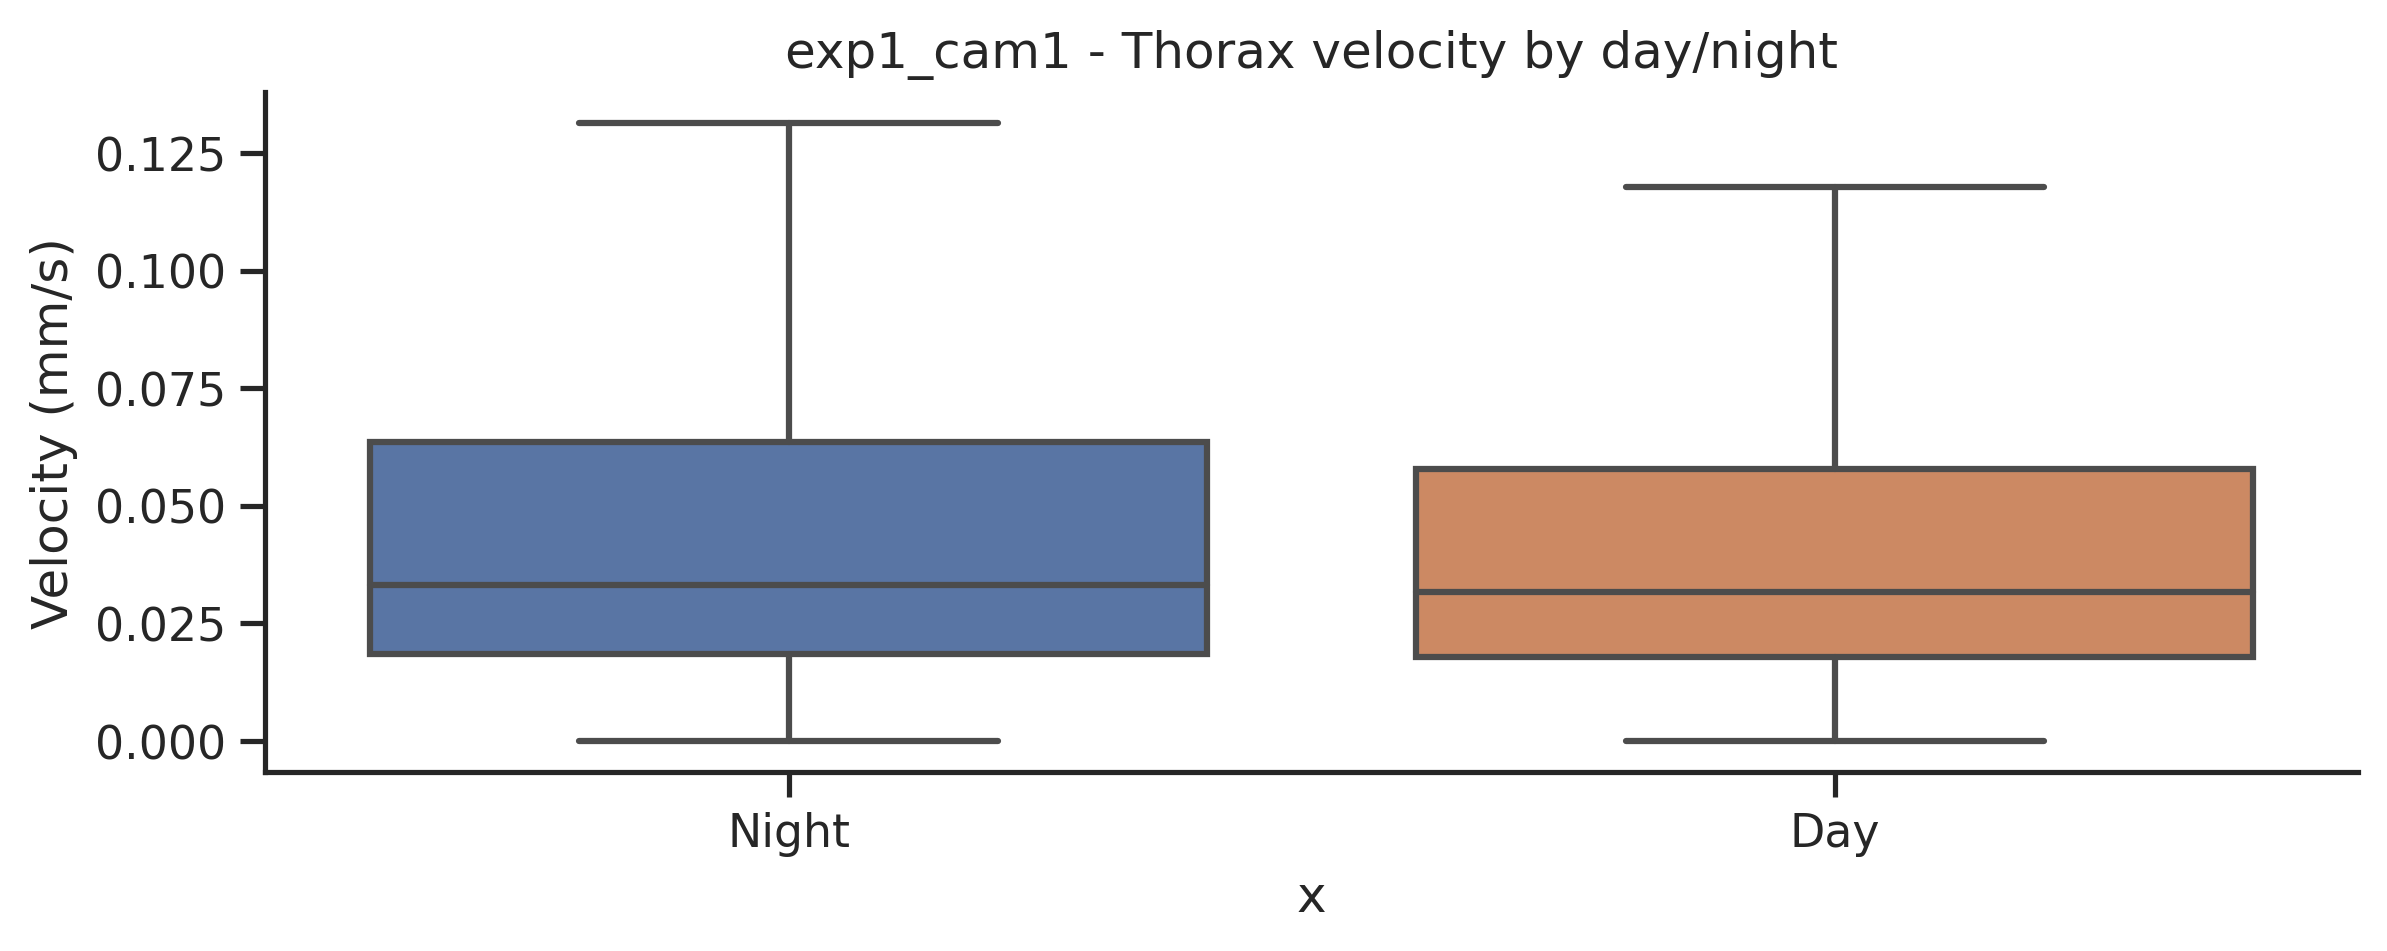

14:51:16 INFO: 24h_bright
14:51:16 INFO: 24h_bright 0
14:51:16 INFO: 24h_bright 1
14:51:16 INFO: 24h_bright 2
14:51:16 INFO: 24h_bright 3


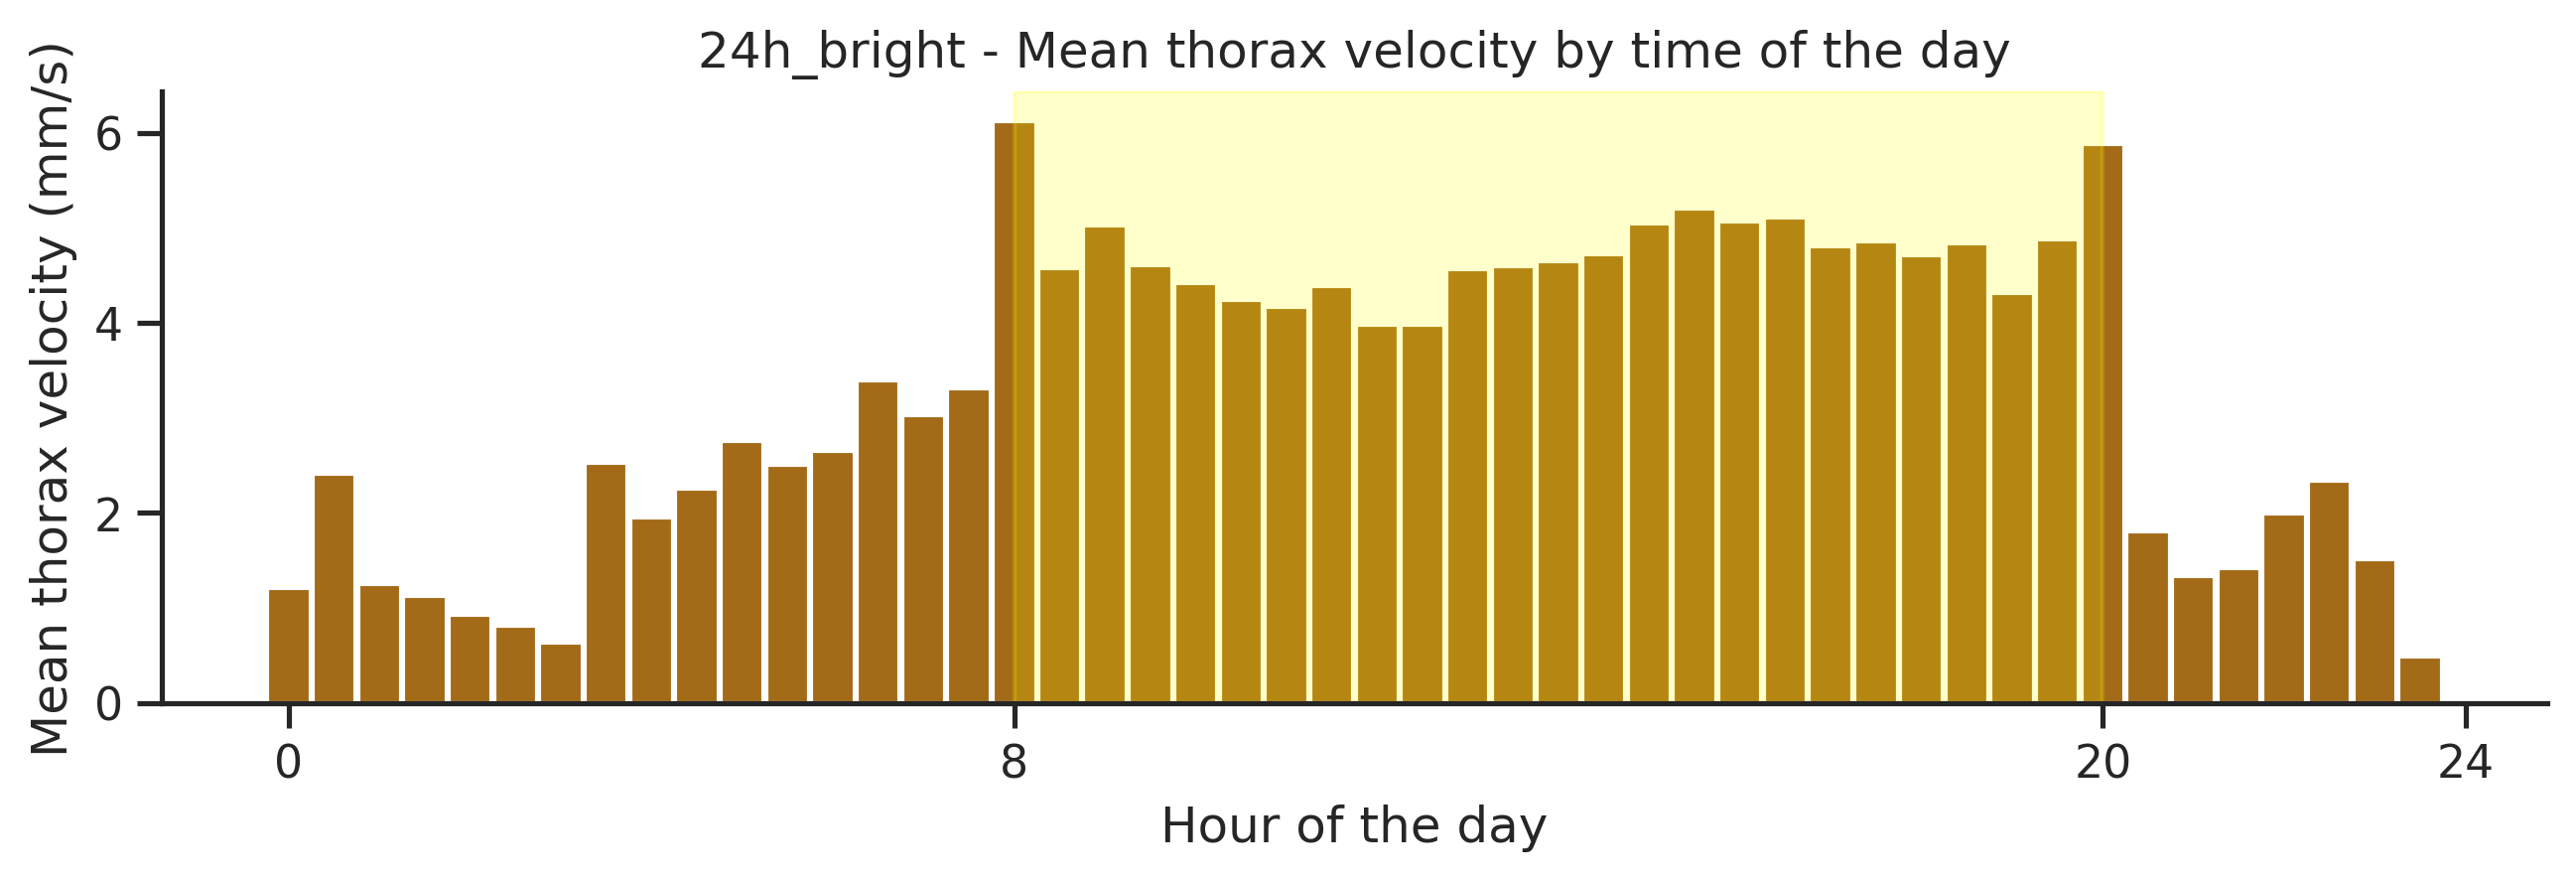

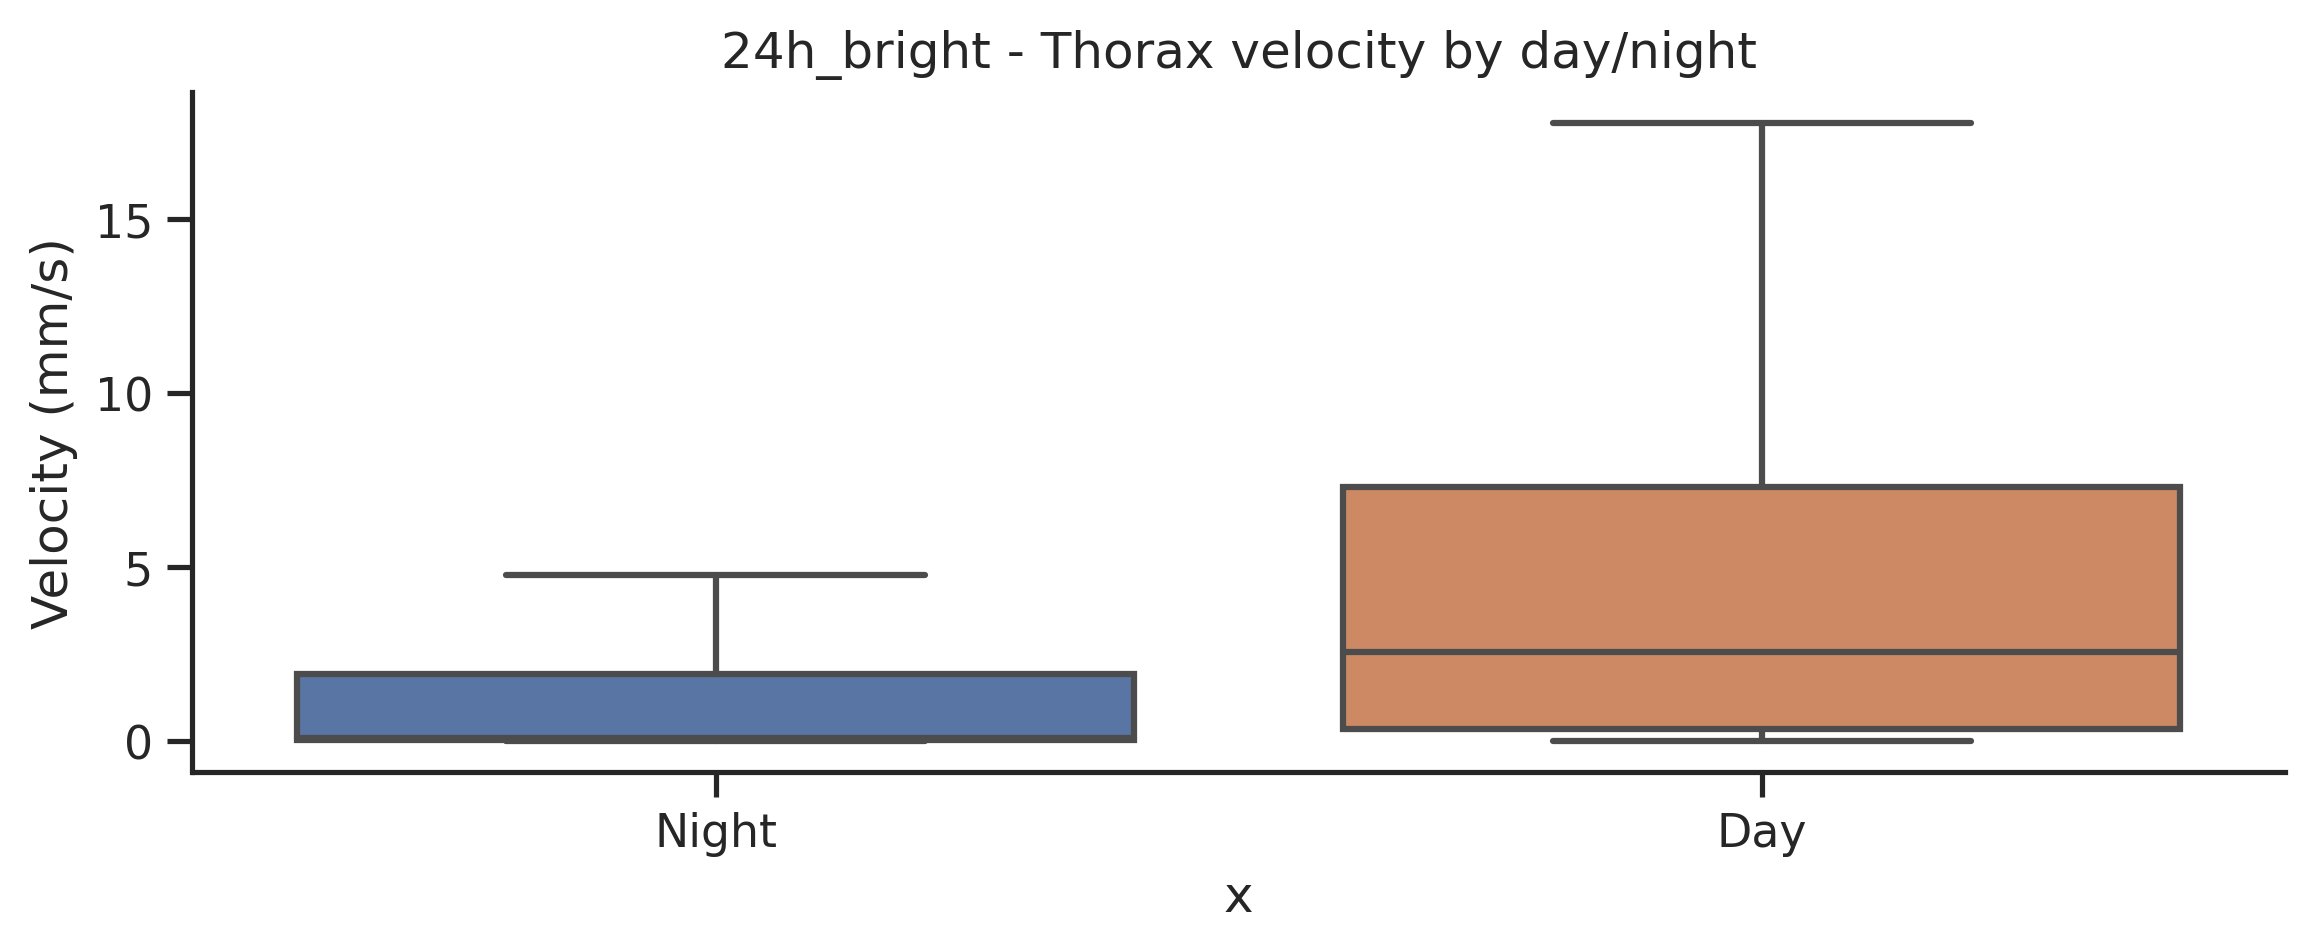

In [8]:

for expmt in expmt_dict:
    logger.info(f"{expmt}")
    vels = velocities_dict[expmt].copy()
    # data[data < .1] = 0
    ToD_list = []
    day_list = []
    fly_thorax_vels_list = []
    for fly_idx in range(4):
        logger.info(f"{expmt} {fly_idx}")
        fly_thorax_vels_list.append(vels[:, node_names.index("thorax"), fly_idx])
        ToD_list.append(ToD[expmt])
        day_list.append(day_dict[expmt])

    ToD_mat = np.concatenate(ToD_list)
    day_mat = np.concatenate(day_list)
    vel_mat = np.concatenate(fly_thorax_vels_list)
    # Number of segments
    segments = 2 * 24
    binned = scipy.stats.binned_statistic(
        ToD_mat, vel_mat, statistic="mean", bins=segments, range=None
    )
    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(style="ticks", rc=custom_params)
    fig, ax = plt.subplots()
    sns.barplot(
        ax=ax,
        x=np.arange(segments),
        y=binned.statistic,
        color=palettable.wesanderson.GrandBudapest4_5.mpl_colors[0],
    )  # ,alpha=1,width=1)
    ticks = [i * (segments // 24) for i in [0, 8, 20, 24]]
    plt.xticks(ticks, [0, 8, 20, 24])
    plt.tight_layout(pad=2)
    # ax.set_yscale('log')
    plt.xlabel("Hour of the day")
    plt.ylabel("Mean thorax velocity (mm/s)")
    plt.title(f"{expmt} - Mean thorax velocity by time of the day")
    trx_utils.change_width(ax, 0.95)
    plt.axvspan(ticks[1], ticks[2], alpha=0.2, color="yellow")
    plt.savefig(
        f"{plots_dir}{plots_prefix}{expmt}_fly{fly_idx}_thorax_velocity_by_hour_of_day.png"
    )
    plt.show()

    
    df = pd.DataFrame({"x": day_mat, "y": vel_mat})
    sns.boxplot(x="x", y="y", data=df, showfliers=False)
    plt.title(f"{expmt} - Thorax velocity by day/night")
    plt.ylabel("Velocity (mm/s)")
    plt.xticks([0, 1], ["Night", "Day"])
    # plt.xlim(0,10)
    plt.savefig(f"{plots_dir}{plots_prefix}{expmt}_thorax_velocity_by_timeofday.png")
    plt.show()


# Plotting fly level information
Now that we know what the distribution looks like at the experiment level, lets take a look at the distribution at the fly level. This should give us a decent idea of if the signal is uniform across individuals

14:51:22 INFO: exp1_cam1 - 0


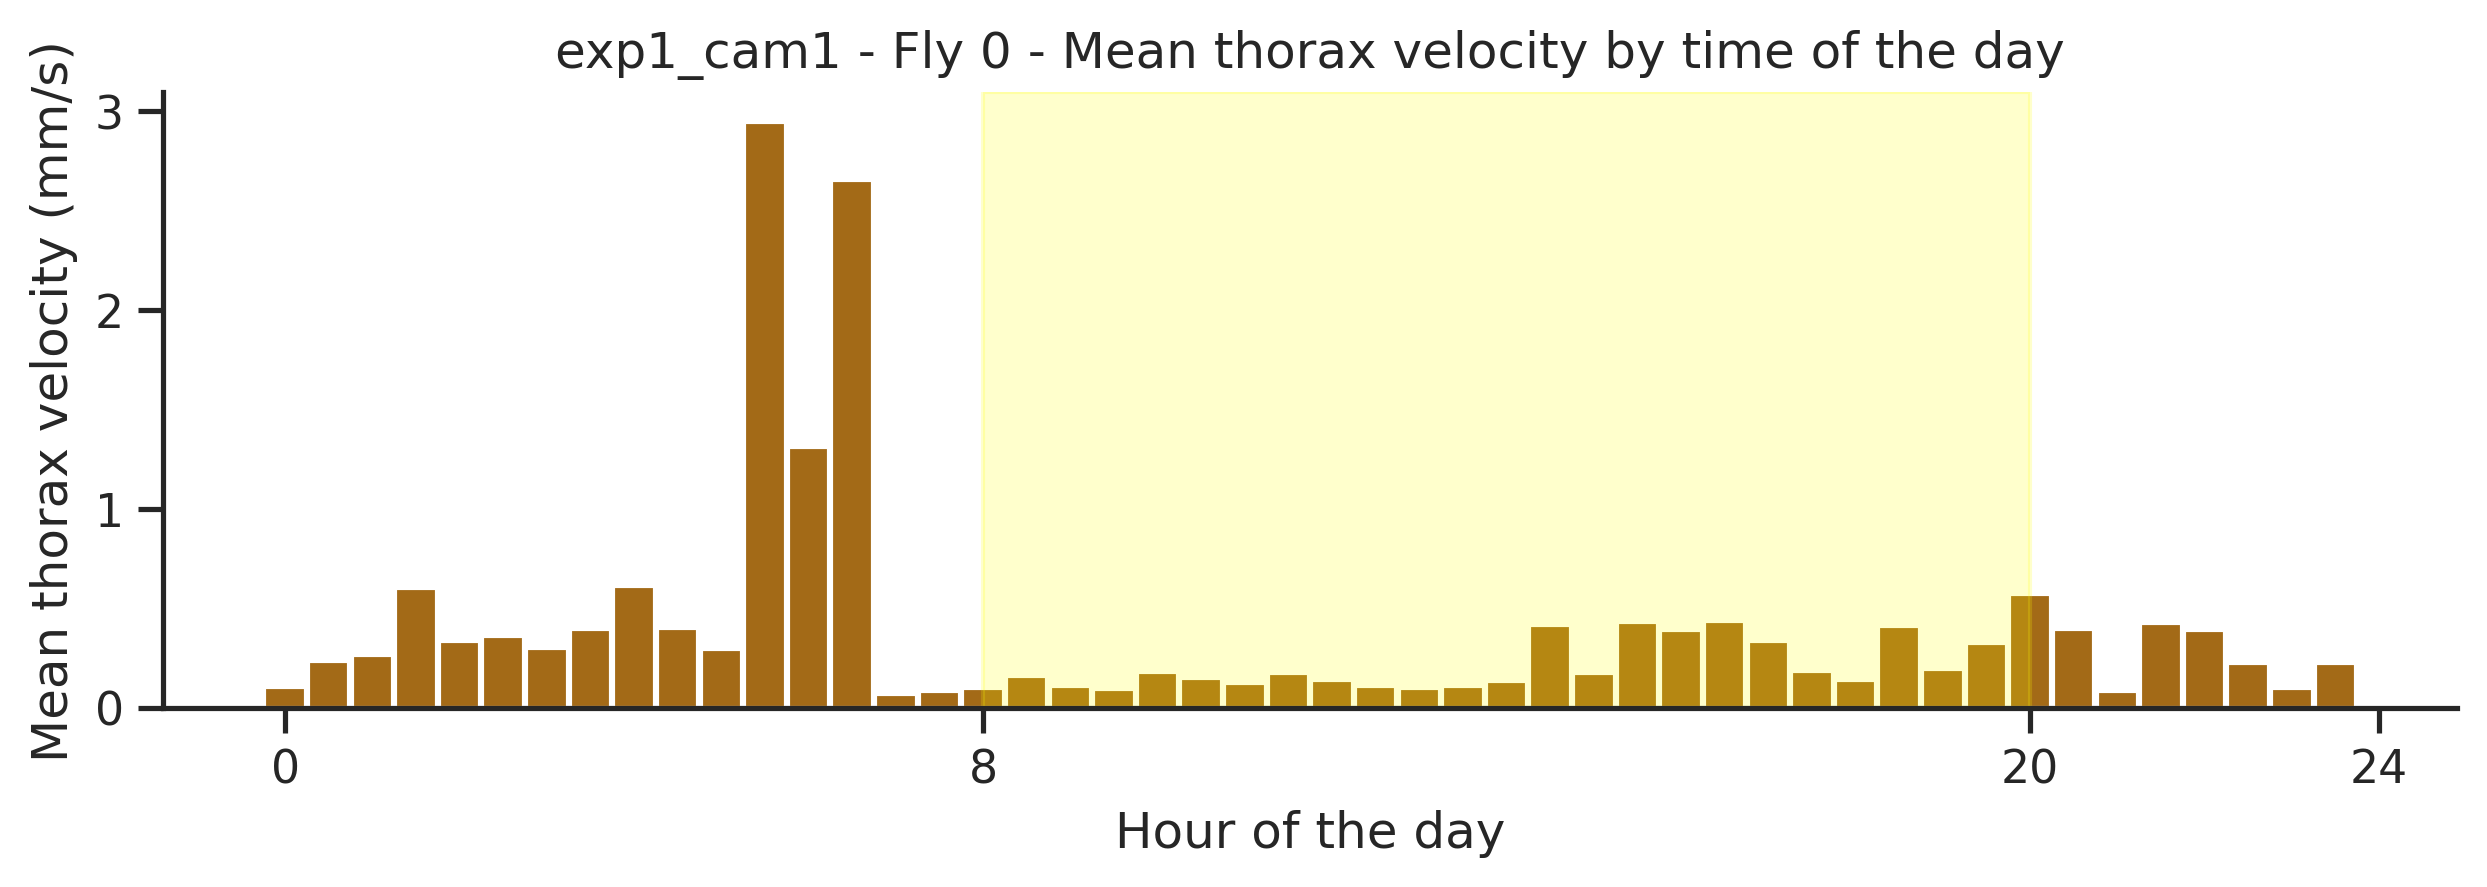

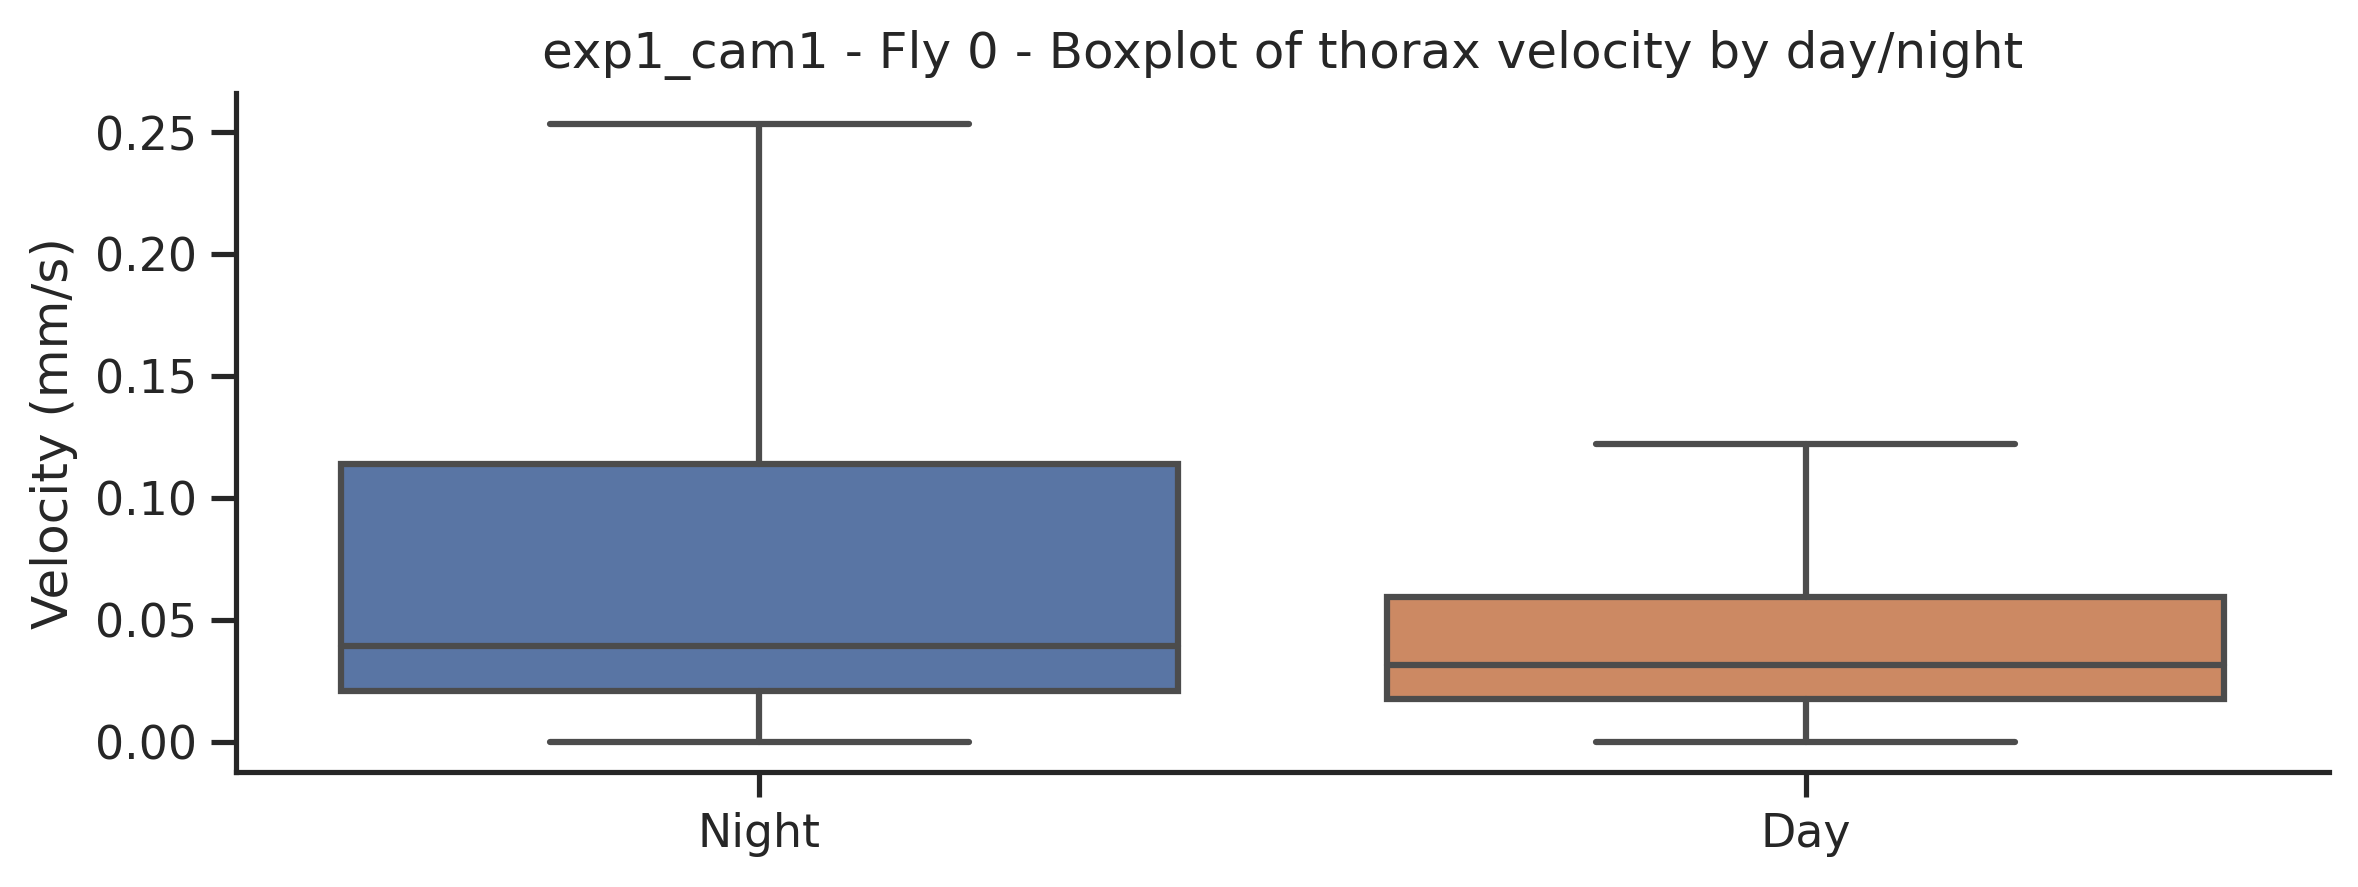

14:51:24 INFO: exp1_cam1 - 1


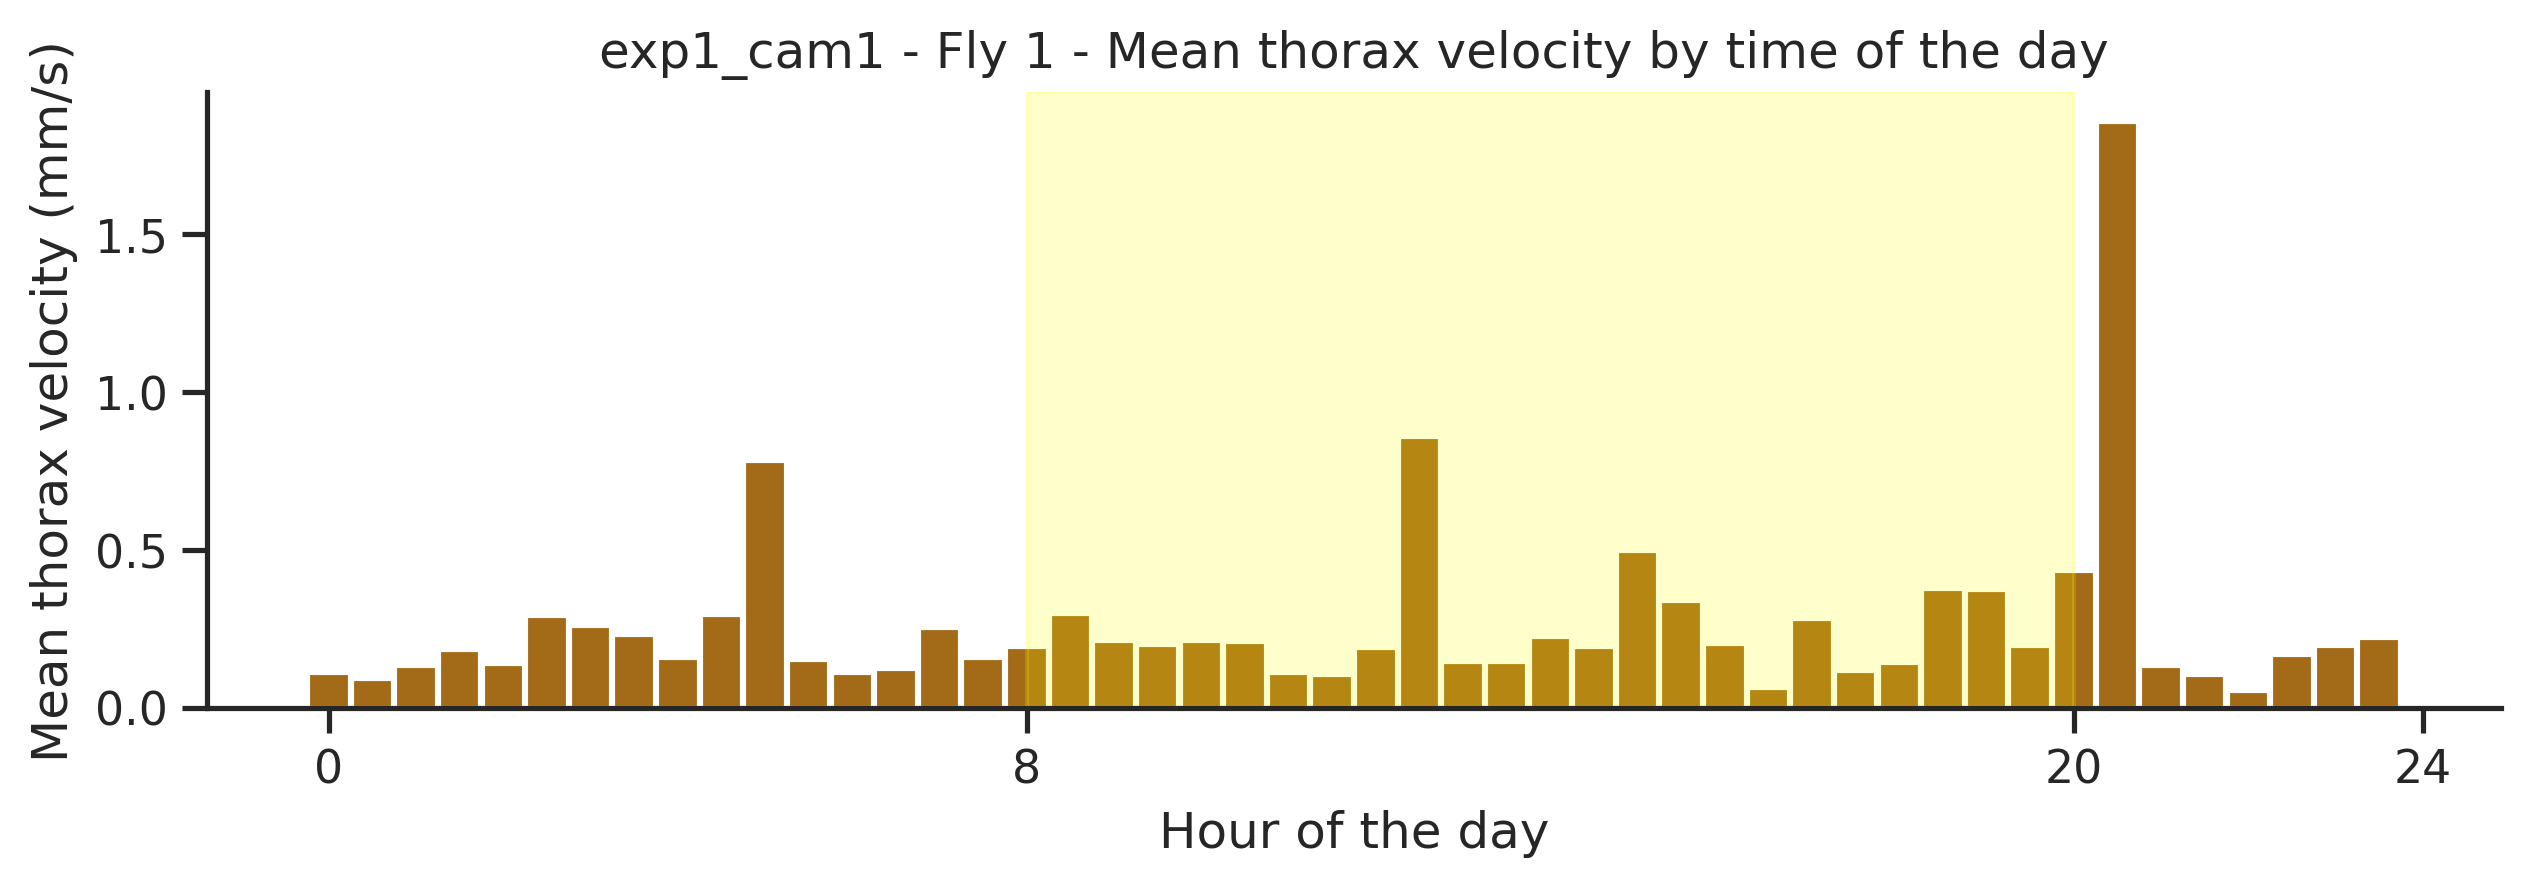

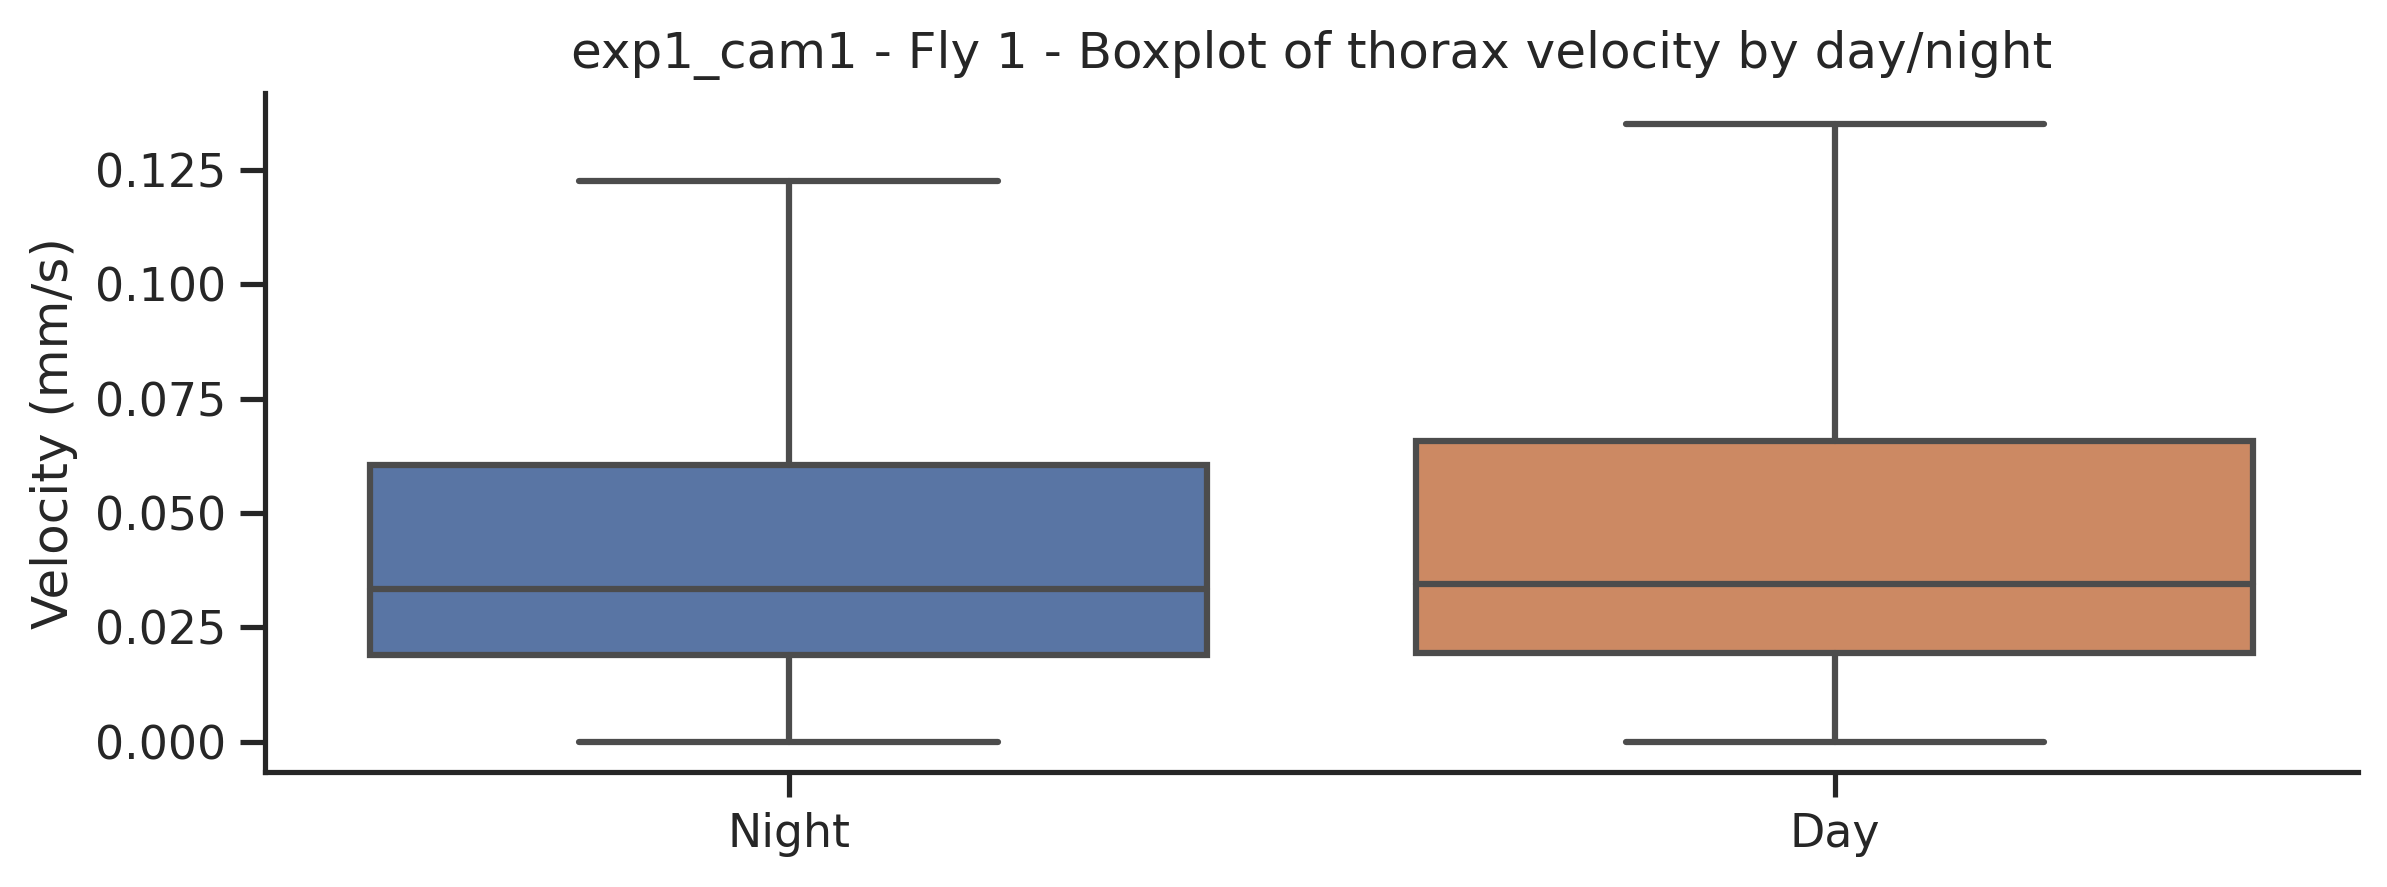

14:51:26 INFO: exp1_cam1 - 2


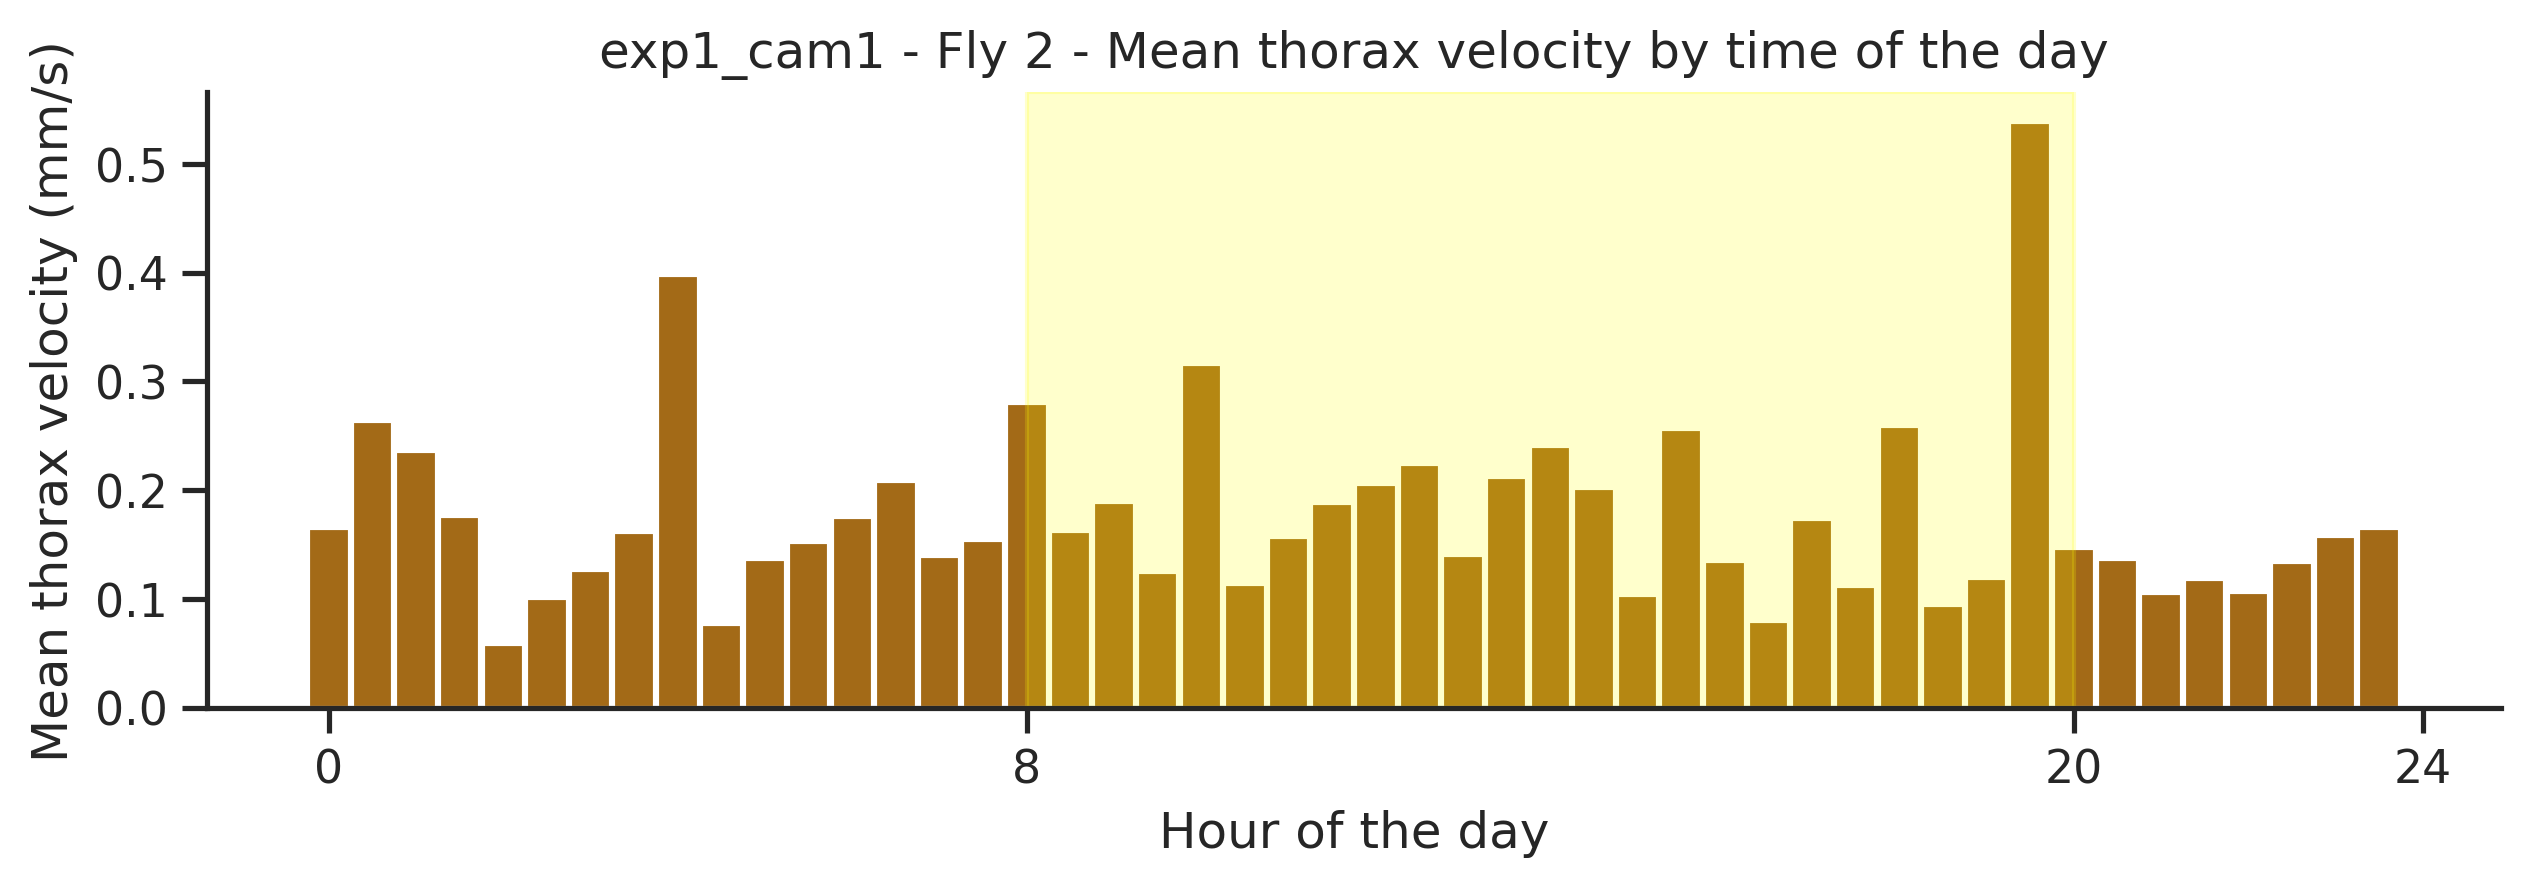

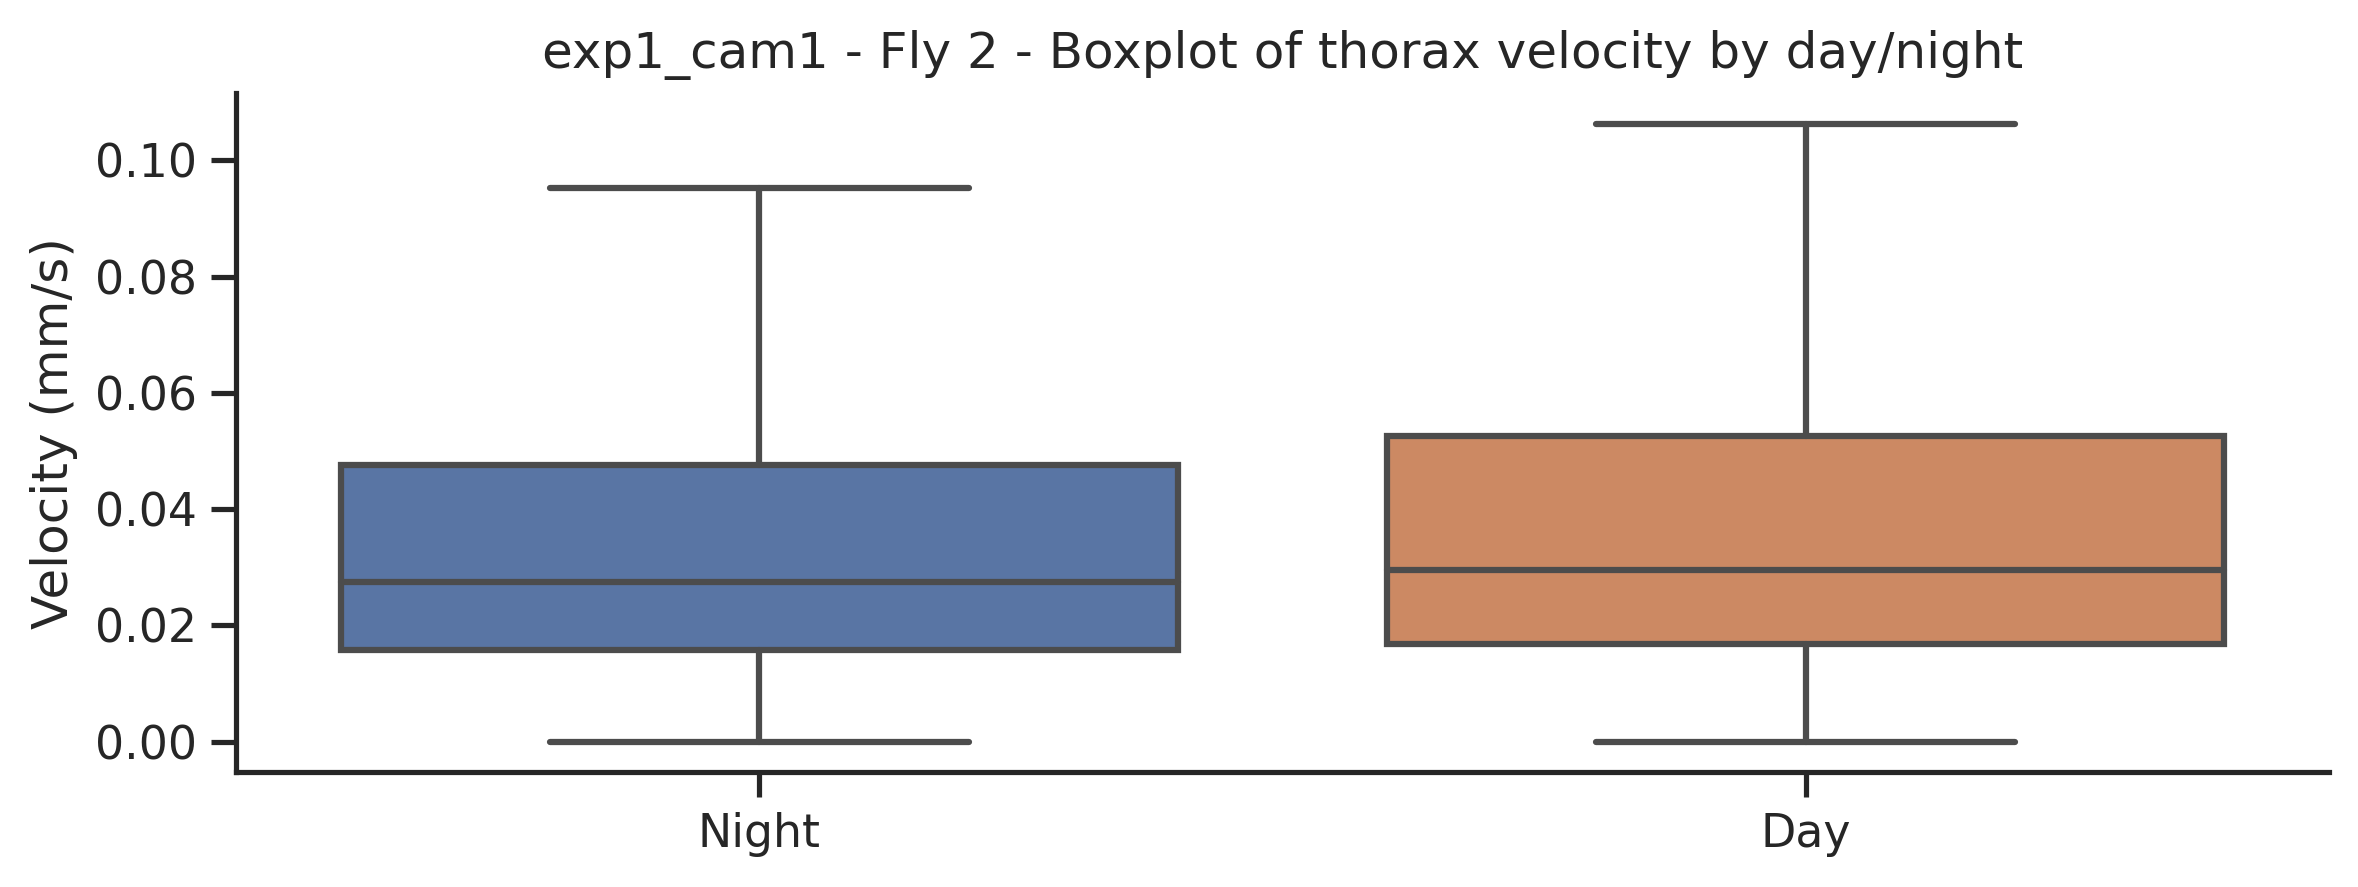

14:51:29 INFO: exp1_cam1 - 3


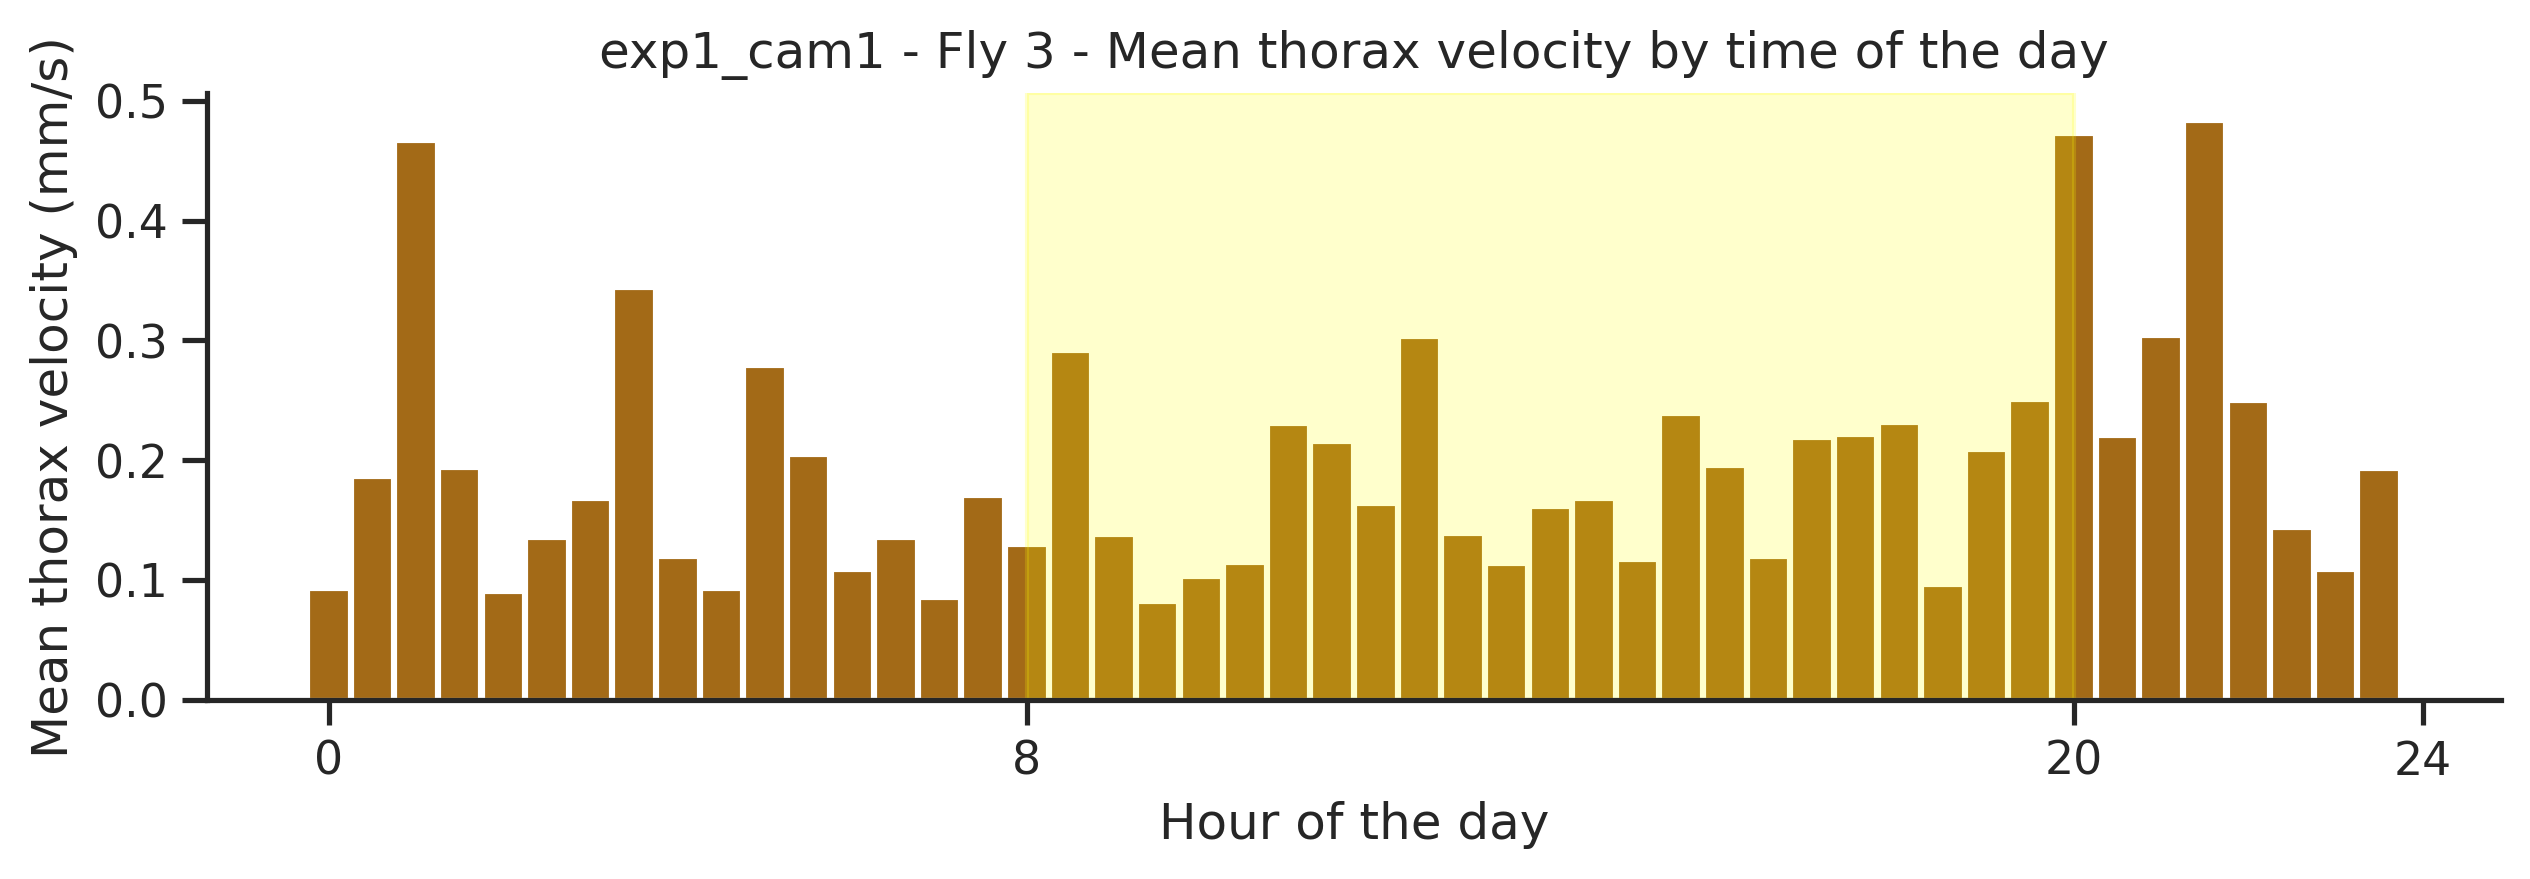

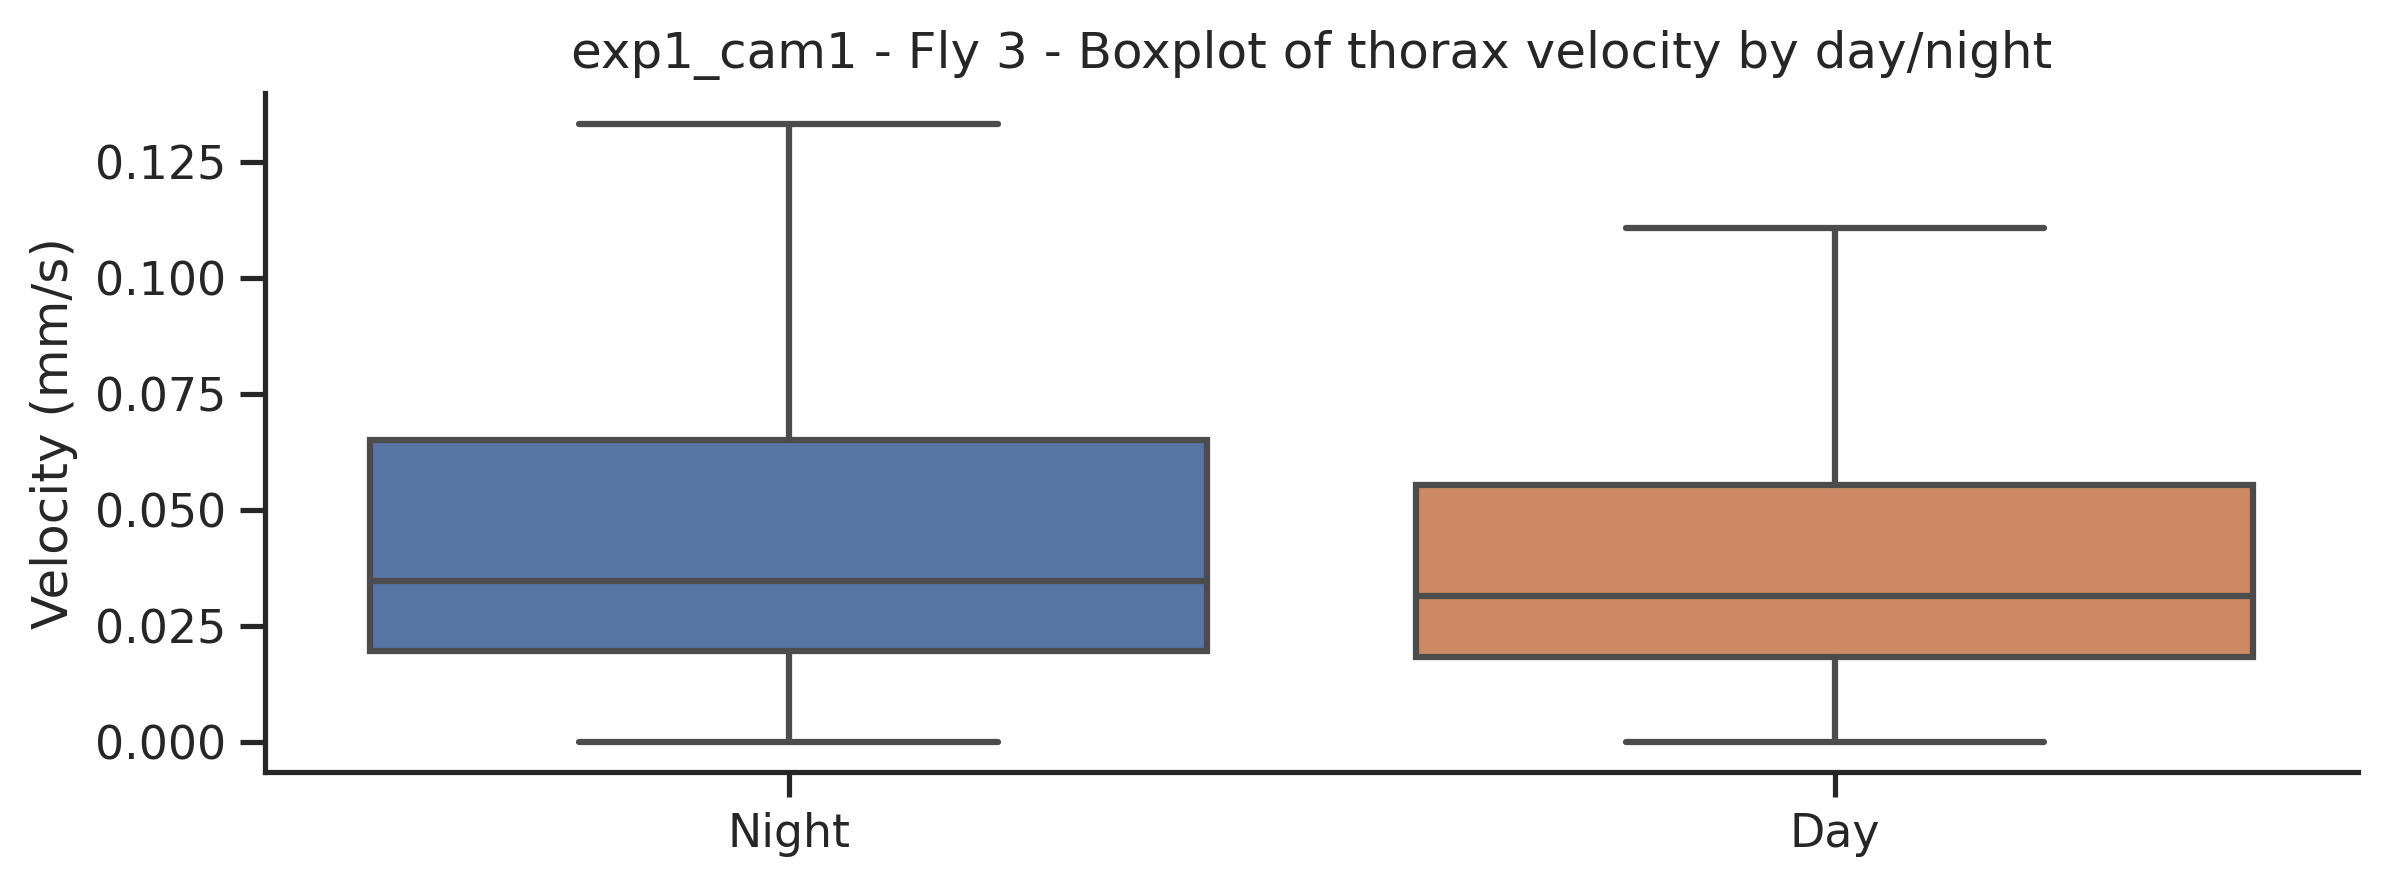

14:51:32 INFO: 24h_bright - 0


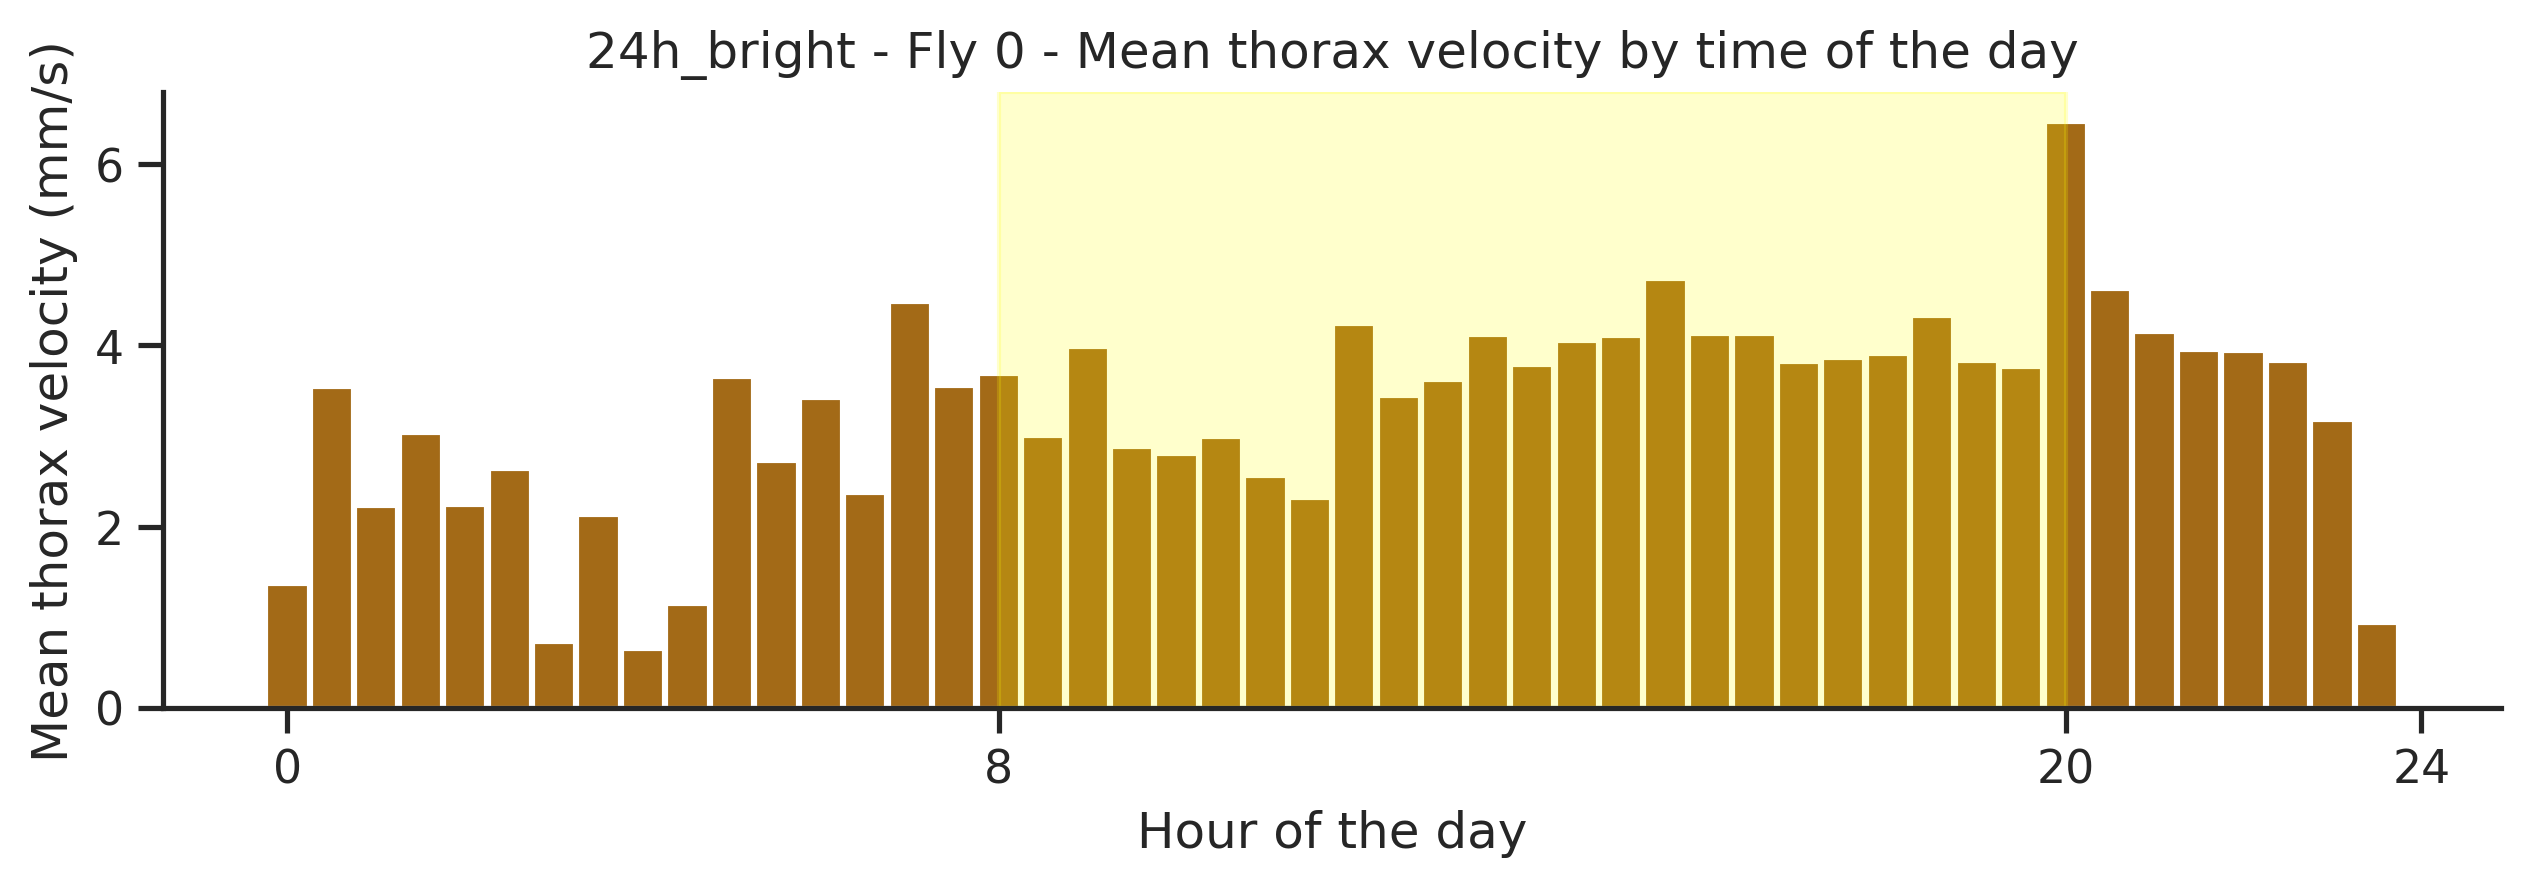

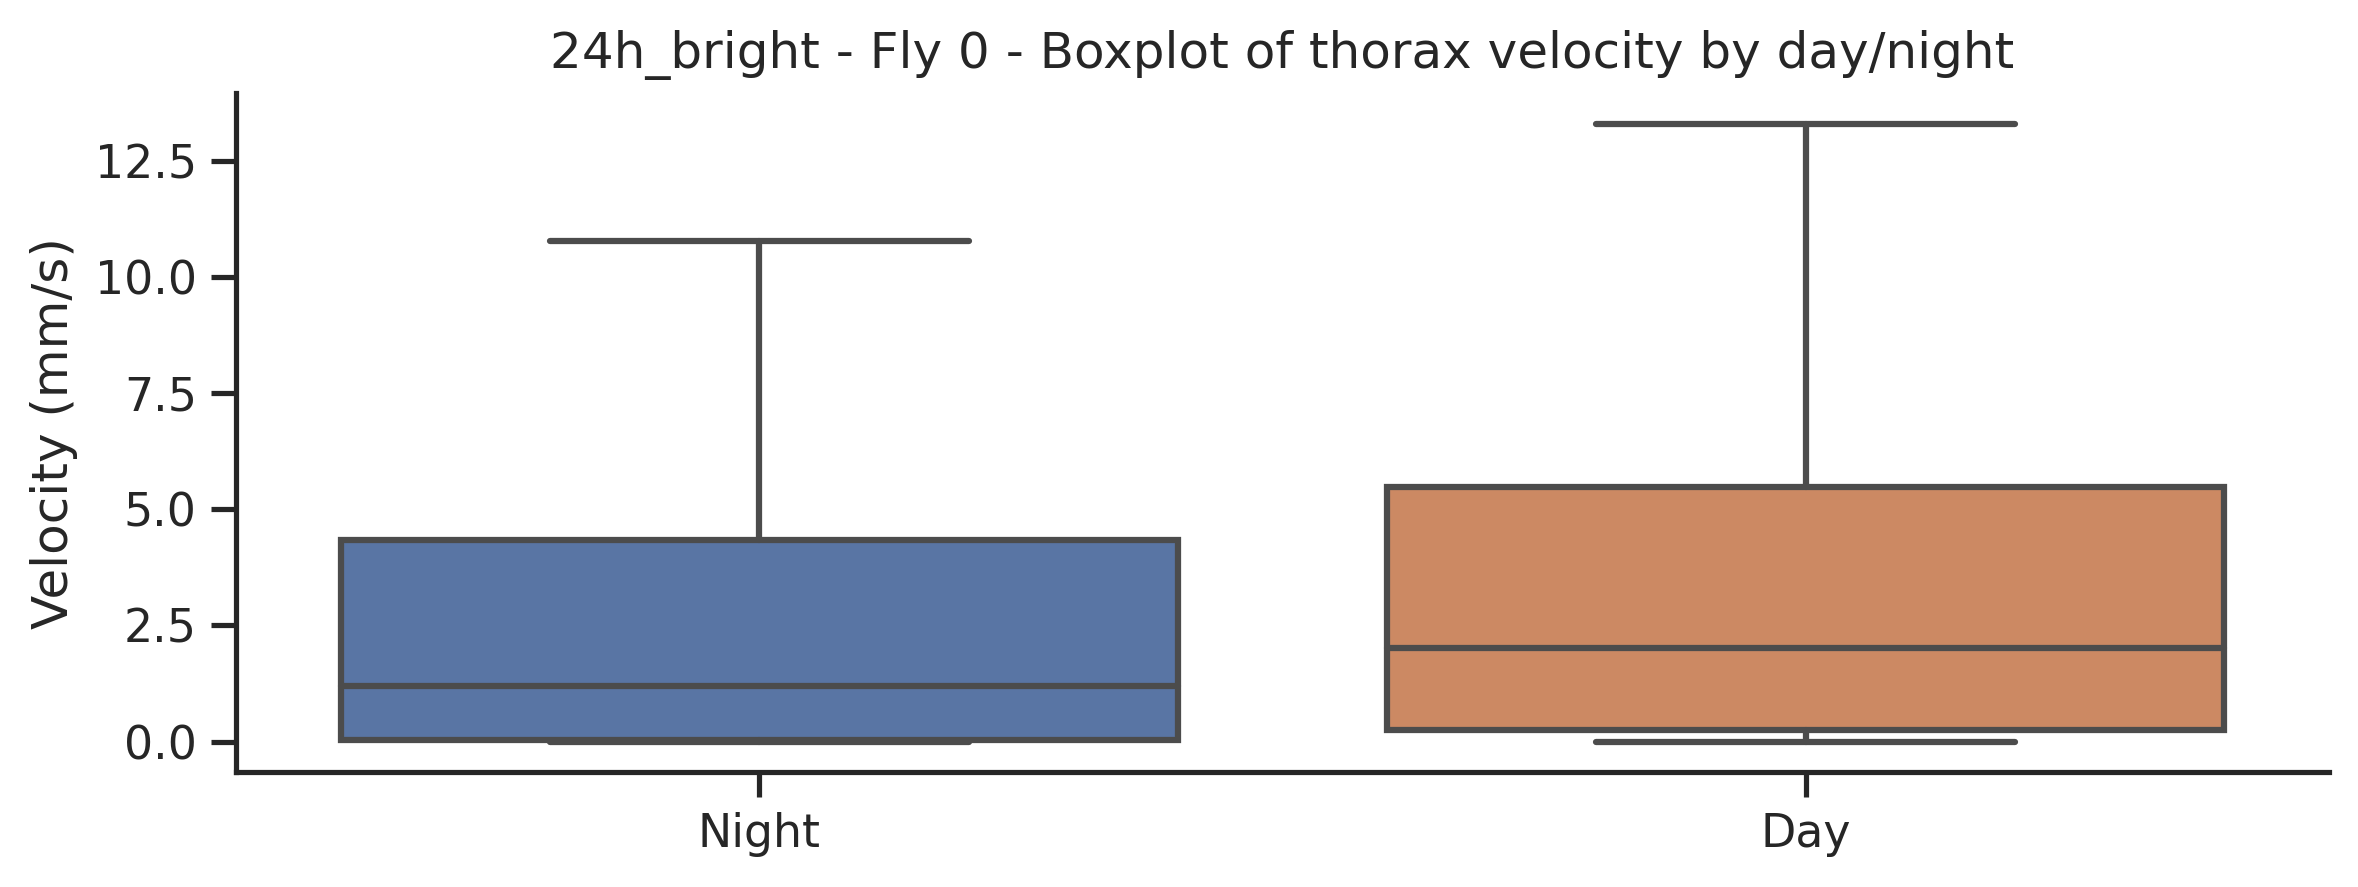

14:51:35 INFO: 24h_bright - 1


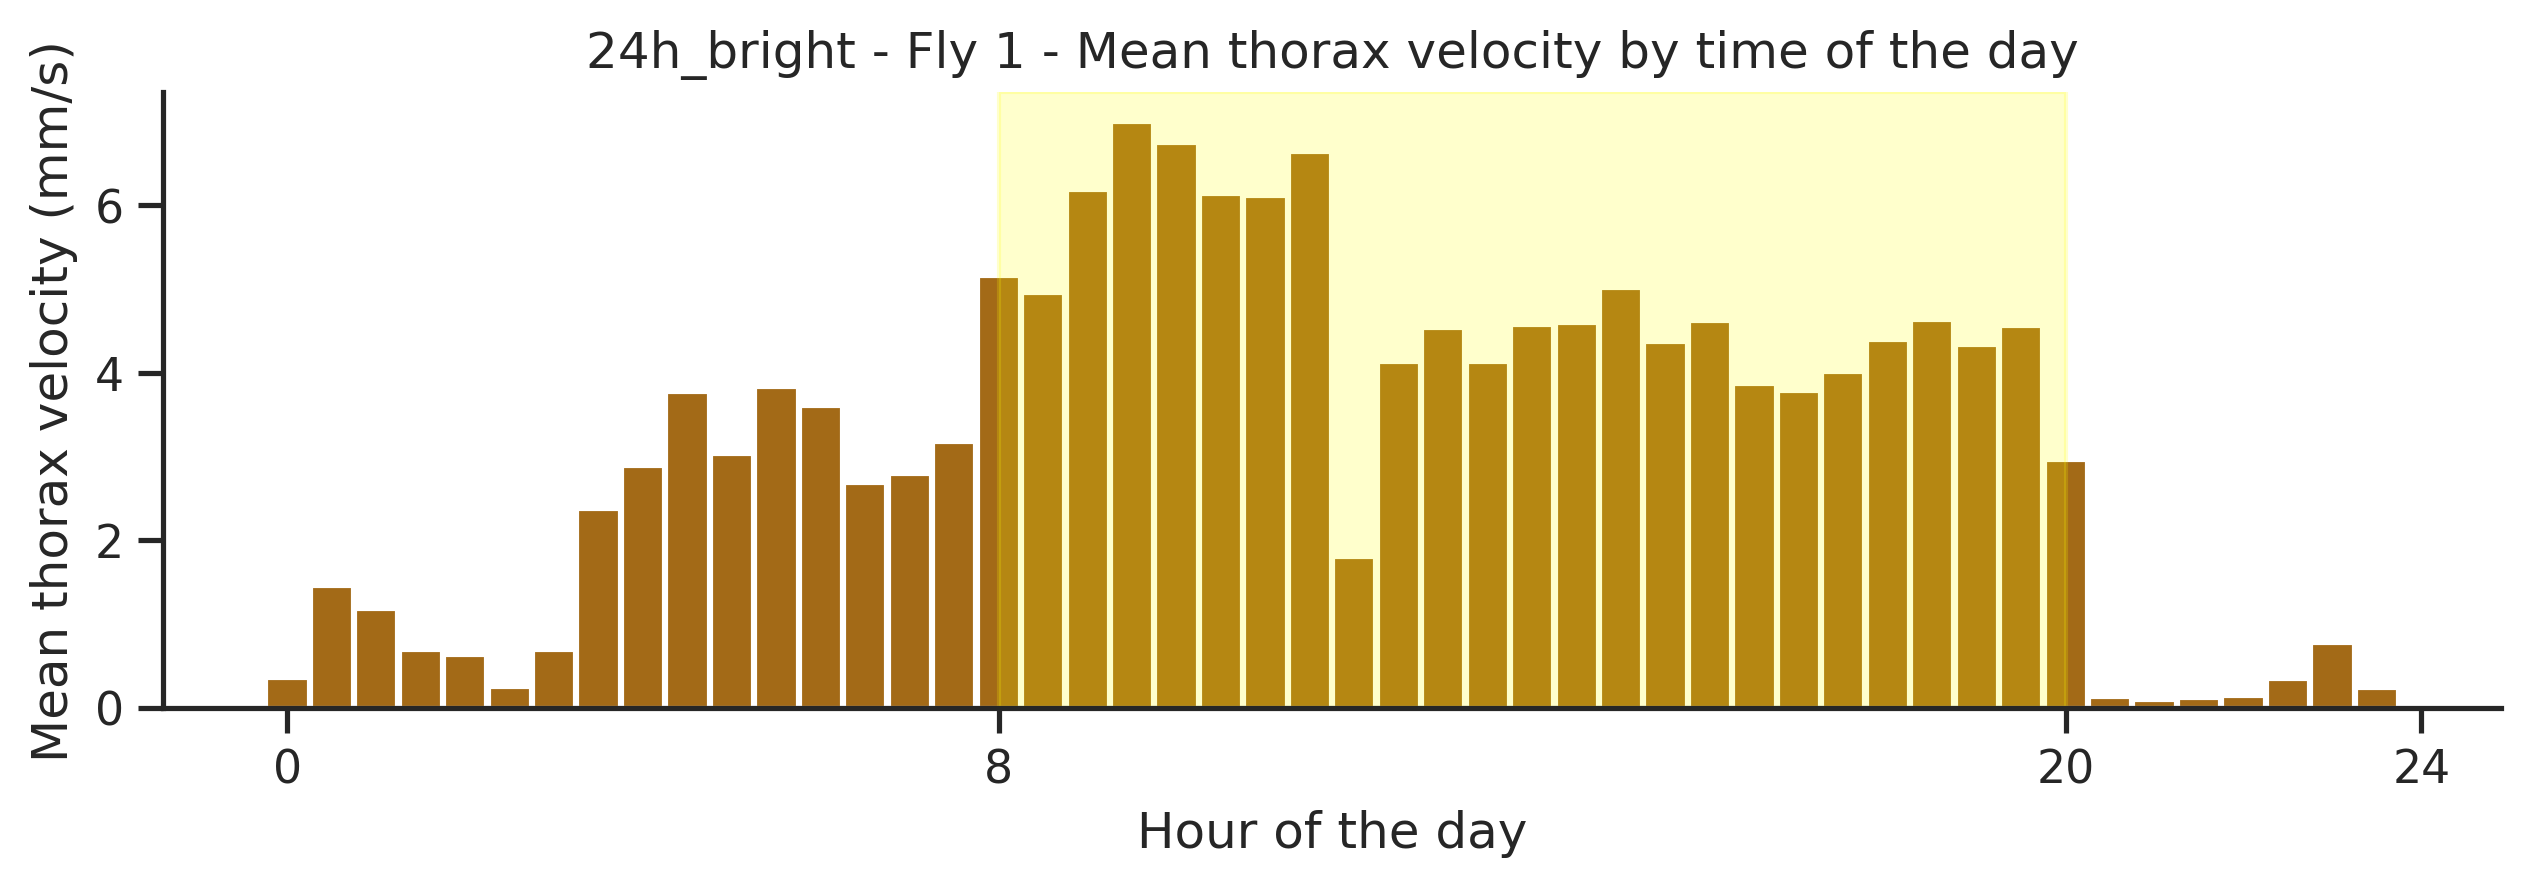

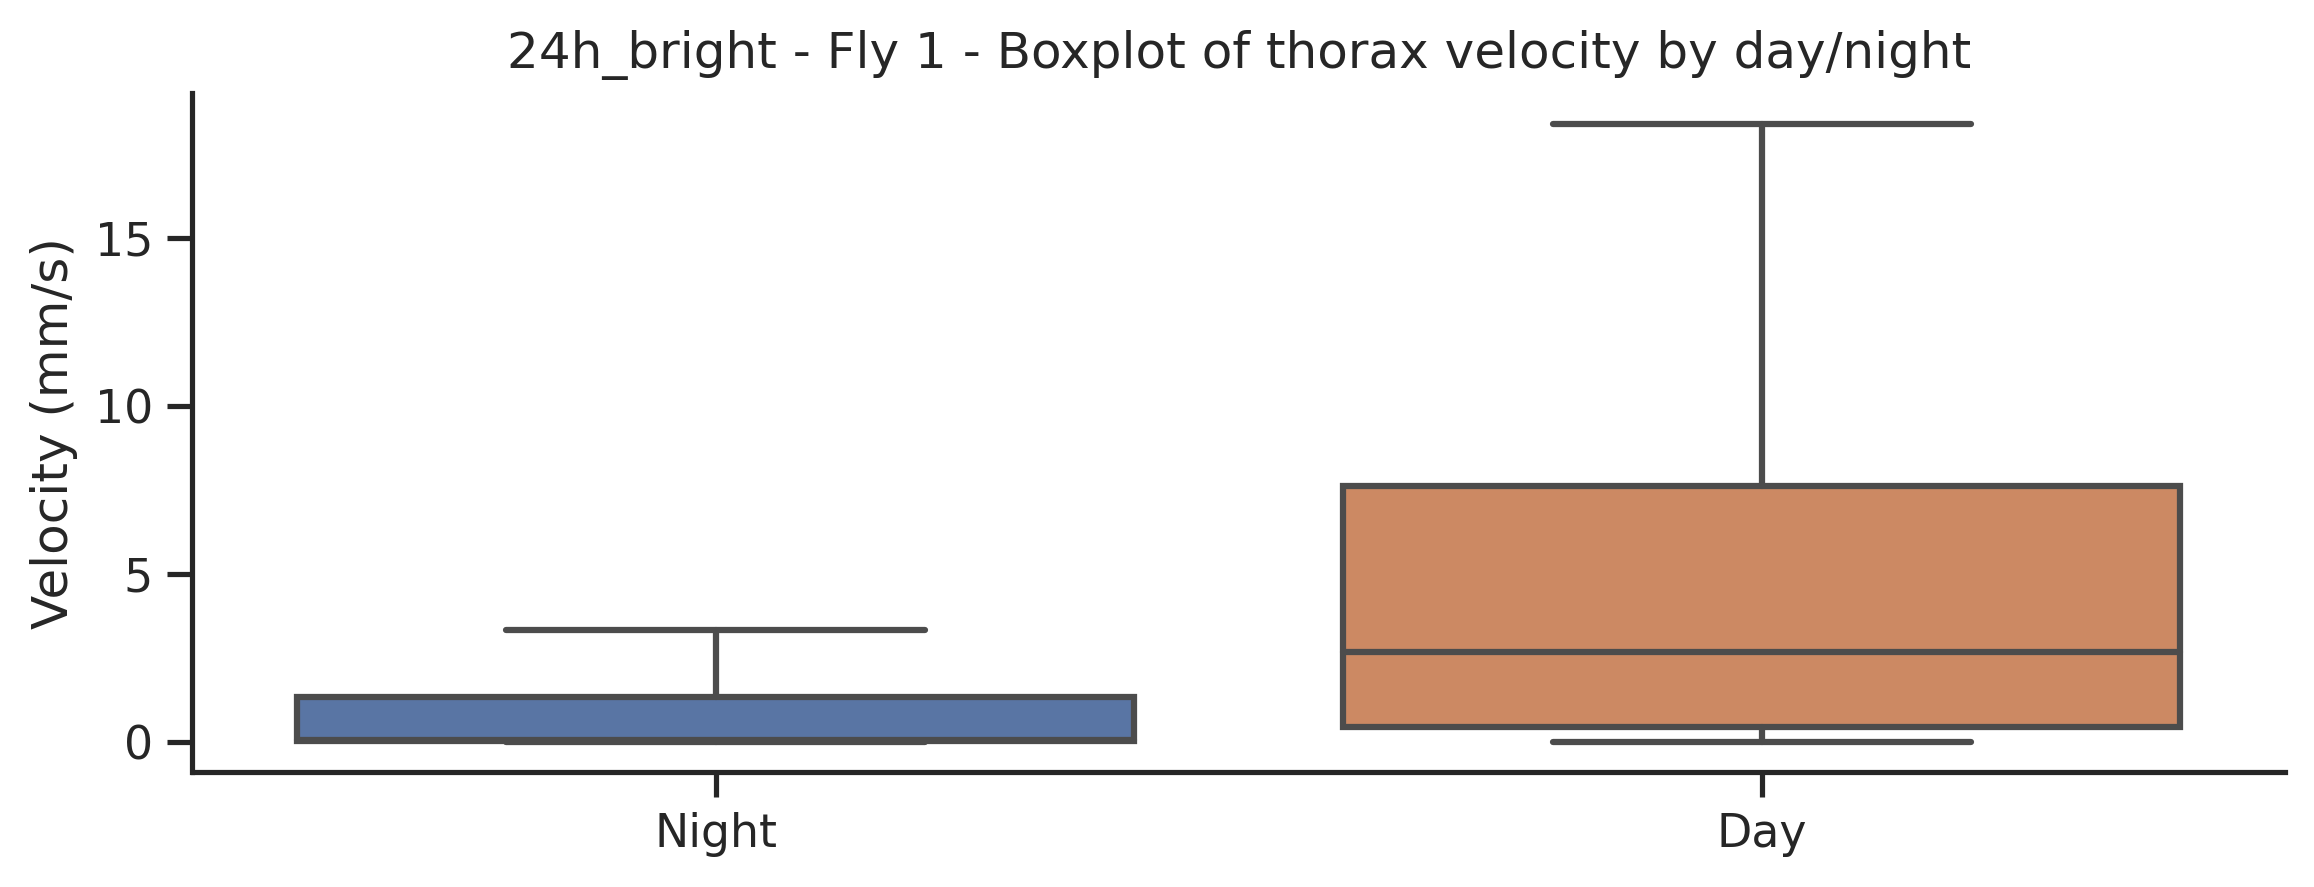

14:51:37 INFO: 24h_bright - 2


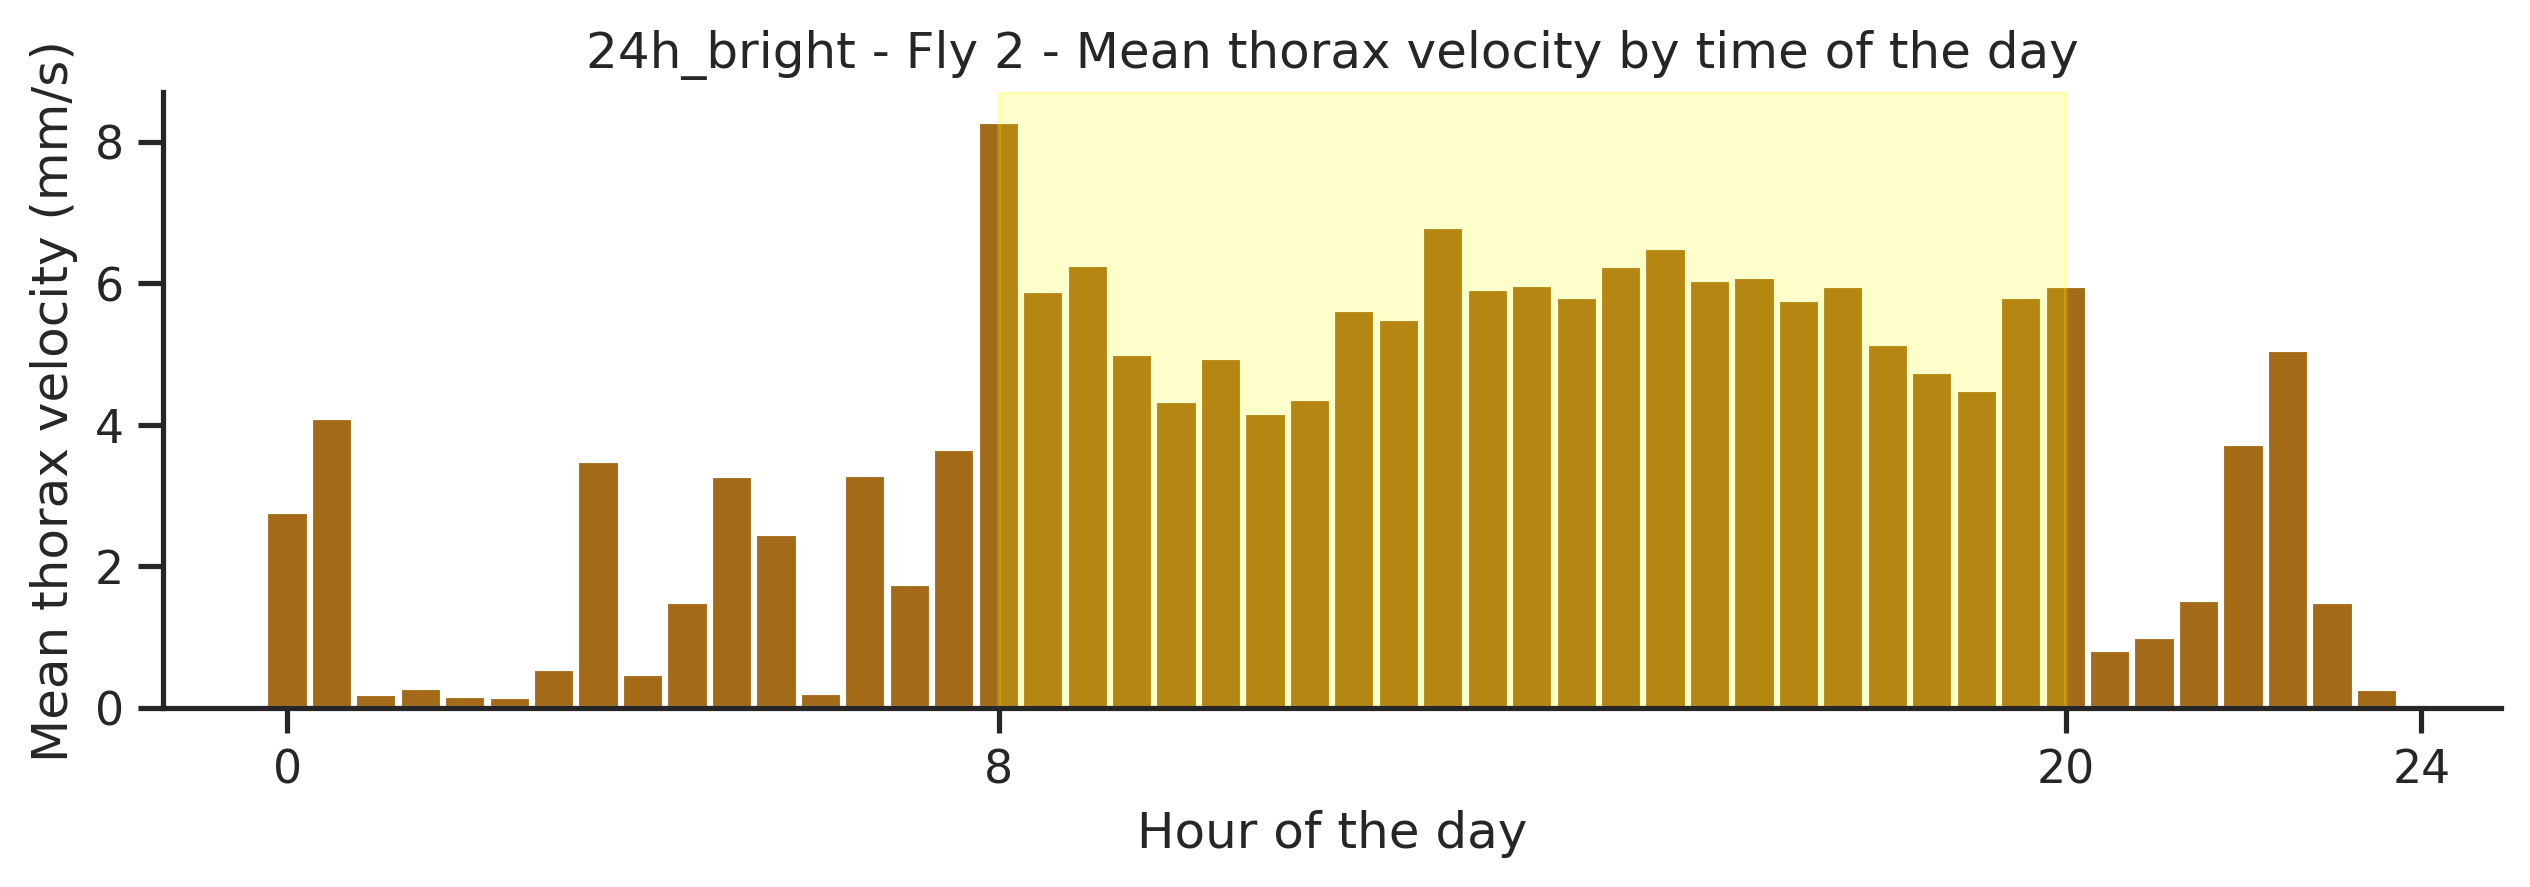

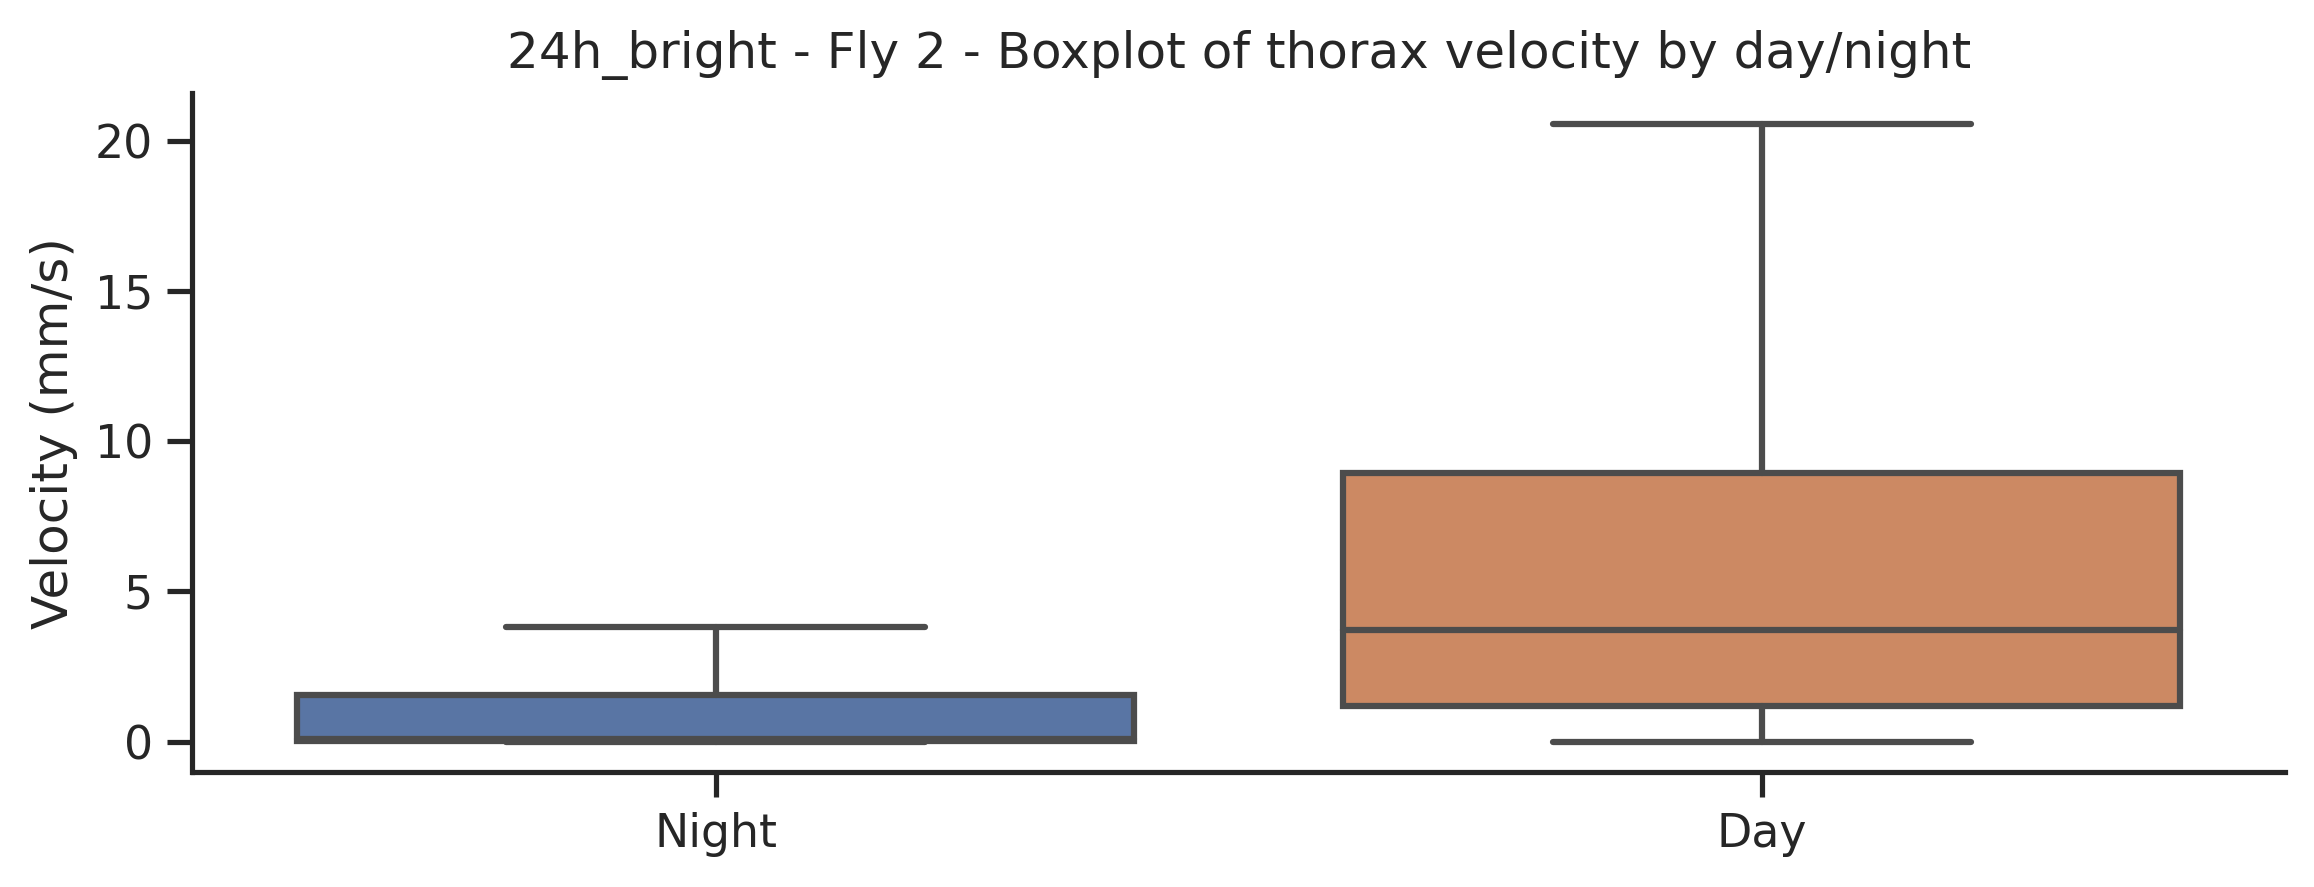

14:51:39 INFO: 24h_bright - 3


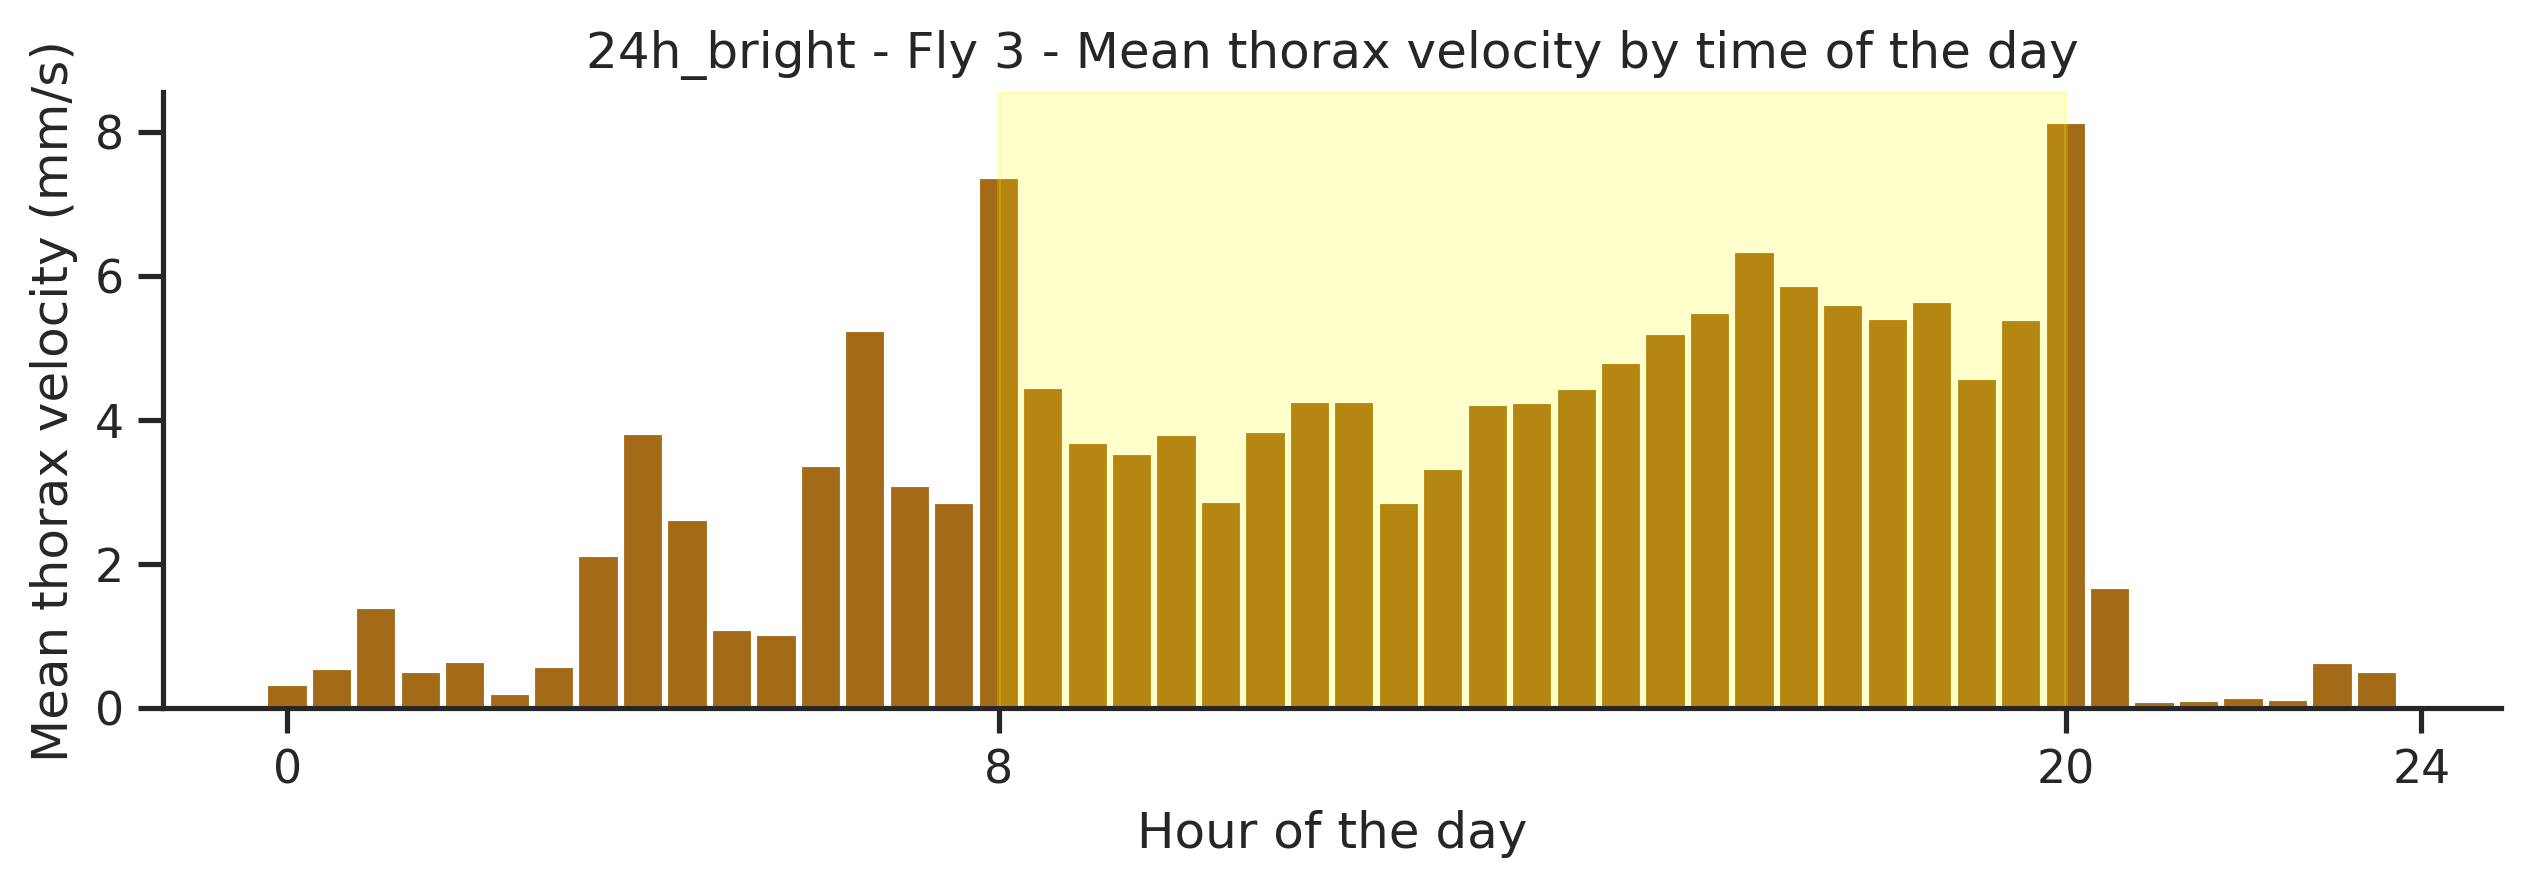

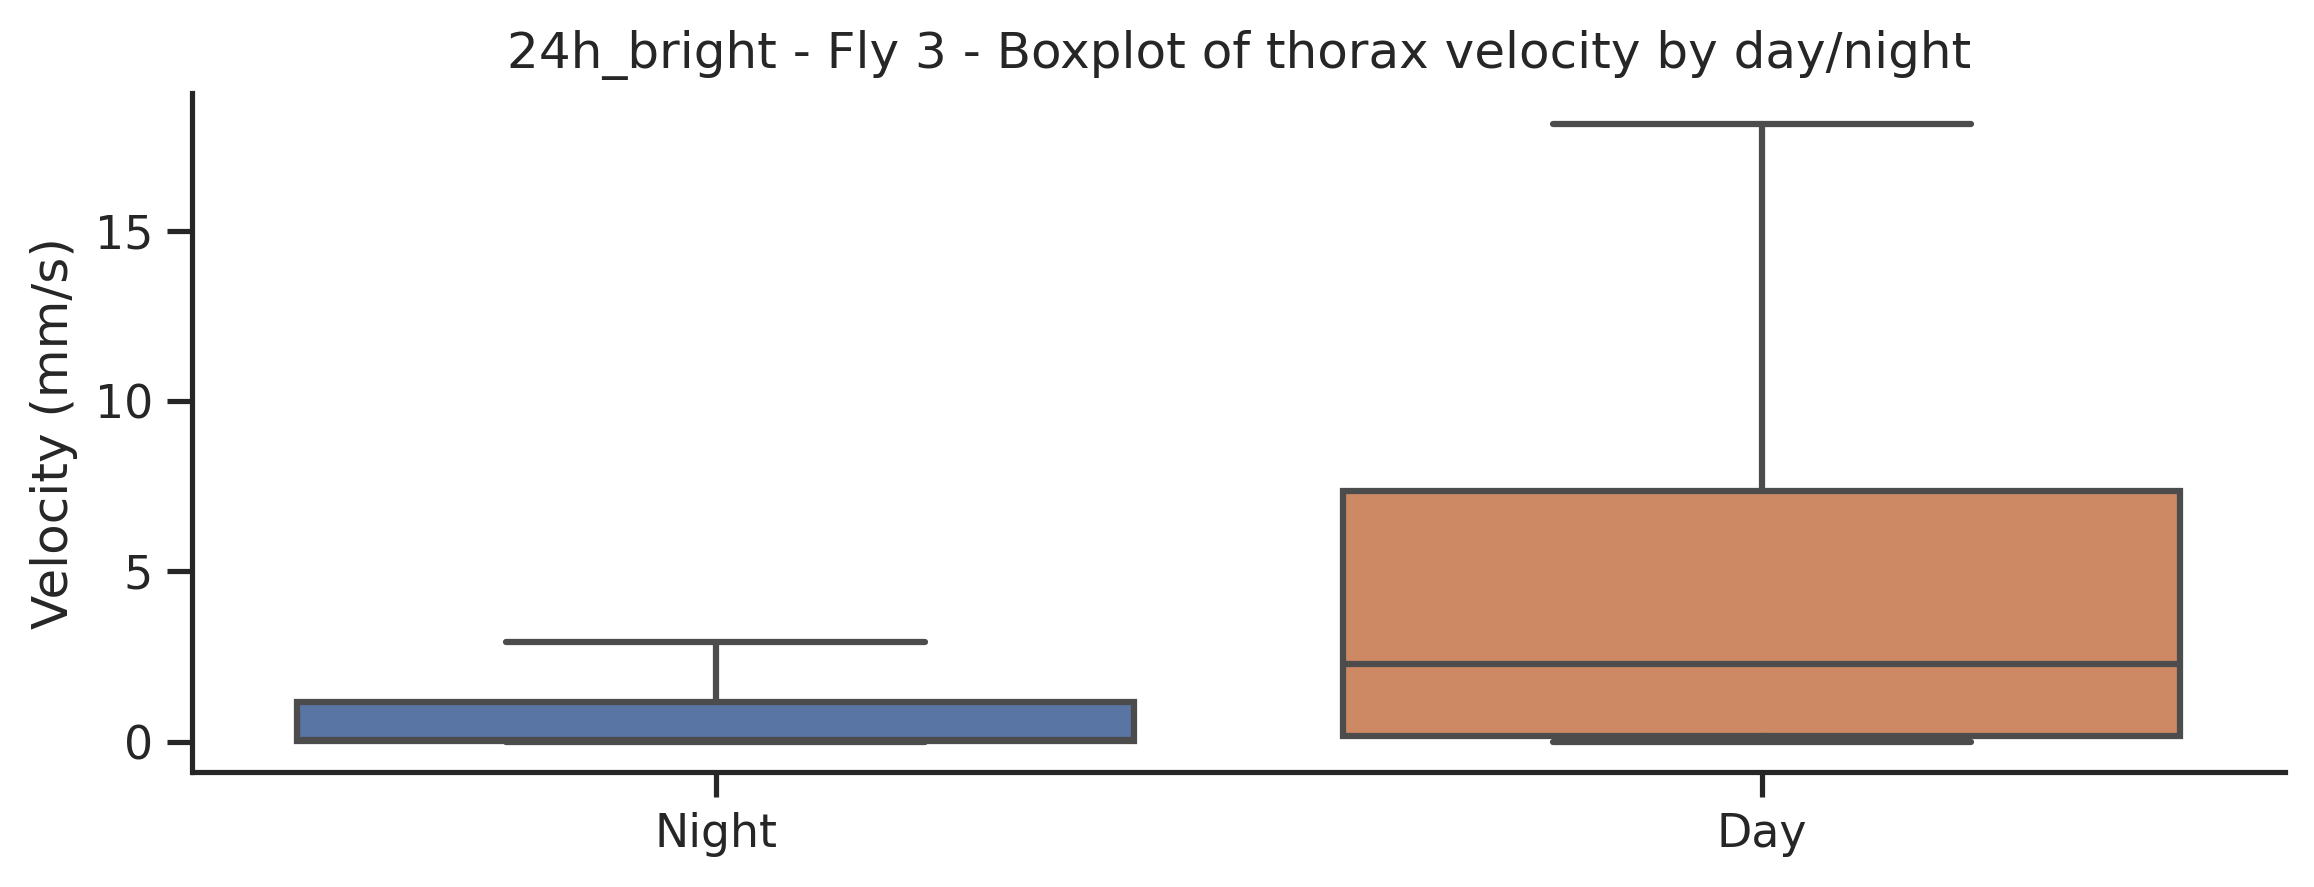

In [9]:
for expmt in expmt_dict:
    vels = velocities_dict[expmt].copy()
    day = (ToD[expmt] > day_start) & (ToD[expmt] < day_end)
    for fly_idx in range(vels.shape[2]):
        logger.info(f"{expmt} - {fly_idx}")
        fly_thorax_vel = vels[:, node_names.index("thorax"), fly_idx]
        binned = scipy.stats.binned_statistic(
            day.astype(int),
            fly_thorax_vel,
            statistic="mean",
            bins=[0, 0.5, 1],
            range=None,
        )

        # Set number of segments we're interested in
        segments = 2 * 24

        binned = scipy.stats.binned_statistic(
            ToD[expmt], fly_thorax_vel, statistic="mean", bins=segments, range=None
        )
        custom_params = {"axes.spines.right": False, "axes.spines.top": False}
        sns.set_theme(style="ticks", rc=custom_params)
        fig, ax = plt.subplots()
        sns.barplot(
            ax=ax,
            x=np.arange(segments),
            y=binned.statistic,
            color=palettable.wesanderson.GrandBudapest4_5.mpl_colors[0],
        )  # ,alpha=1,width=1)
        plt.ylabel("Velocity (mm/s)")
        ticks = [i * (segments // 24) for i in [0, 8, 20, 24]]
        plt.xticks(ticks, [0, 8, 20, 24])
        plt.tight_layout(pad=2)

        plt.xlabel("Hour of the day")
        plt.ylabel("Mean thorax velocity (mm/s)")
        plt.title(f"{expmt} - Fly {fly_idx} - Mean thorax velocity by time of the day")
        trx_utils.change_width(ax, 0.95)
        plt.axvspan(ticks[1], ticks[2], alpha=0.2, color="yellow")
        plt.savefig(
            f"{plots_dir}{plots_prefix}{expmt}_fly{fly_idx}_thorax_velocity_by_hour_of_day.png"
        )
        plt.show()

        #
        sns.boxplot(x=day.astype(int), y=fly_thorax_vel, showfliers=False)
        plt.xticks([0, 1], ["Night", "Day"])
        plt.ylabel("Velocity (mm/s)")
        plt.title(f"{expmt} - Fly {fly_idx} - Boxplot of thorax velocity by day/night")

        plt.savefig(
            f"{plots_dir}{plots_prefix}{expmt}_fly{fly_idx}_thorax_velocity_boxplot_daynight.png"
        )
        plt.show()

        # A bar plot if we want it!
        # sns.barplot(x=["Night", "Day"], y=binned.statistic)
        # plt.title(f"{expmt} - Fly {fly_idx} - Mean thorax velocity by day/night")
        # plt.show()
